## to do the analysis:
-	iloc warnings update to current version.
-	3d plots with bodyweight
- 	auc plots logy axis 


## Plots for manuscript
Which plots:
-   caffeine clearance / doses
-   caffeine half life / doses/kg
Different variants of plot
- only strict data & remove outliers & rest! (describe the criteria of data selection in legend, i.e. healthy, smoking, ...; and outlier removal!); for males oc=F must be inferred -> check and document;
- create rest/unknown category of all data which has missing smoking or oc information.
- all symbols are circles!, only change colors for subgroups: control, smoking, oc, oc-smoking, rest
- Two variants of plot: (i) only raw outputs and (ii) raw outputs + calculated (used different symbol for calculated)
- check errorbars for dose/kg 
- make plot square
- doses in [mg] and [mg/kg]; clearance in [ml/min]; thalf [hr];
- size of marker according to groupsize
- more concise legend,e.g., control (I=190, G=47, TI=2001)
- remove title, remove grid
- add histograms on y-Axis
- add interpolation curve for groups

- Create same plots with outliers + rest (supplement) & clearly mark the outliers and rest with different symbols;




## Manuscript: 

- update figure 3 second image (strict query) (make image legend and write method section ( how was the image created)
- add overview tables in suplements
- substance diagram on left side (add legend , add method section)


In [1]:
import pandas as pd
import numpy as np
from collections import namedtuple
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D
import os
plt.style.use('seaborn-white')
import matplotlib
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker



from utils import PkdbModel, abs_idx,rel_idx,group_idx,individual_idx \

plt.rcParams.update({
        'axes.labelsize': '20',
        'axes.labelweight': 'bold',
        'axes.titlesize': 'medium',
        'axes.titleweight': 'bold',
        'legend.fontsize': '20',
        'xtick.labelsize': '20',
        'ytick.labelsize': '20',
        'figure.facecolor': '1.00'
    })


{'token': '4241a1580f26a51f470a716cbb84be132808f5a3'}


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
caffeine_clr = PkdbModel("caffeine_clearance",destination="3-inferred")
caffeine_clr.read()
caffeine_clearance = caffeine_clr.data
caffeine_clearance["outlier"] = False


In [4]:
# filter out outliers probably from same clinical study 

In [5]:
caffeine_clearance.loc[caffeine_clearance["study"]== "Balogh1992","outlier"] = True
caffeine_clearance.loc[caffeine_clearance["study"]== "Harder1988","outlier"] = True
caffeine_clearance.loc[caffeine_clearance["study"]== "Harder1989","outlier"] = True

In [6]:

def control_idx(data):
    return ( data[ ('smoking', 'choice')] == 'N') \
           & (data.outlier == False) \
           & ((data[ ('oral contraceptives', 'choice')] == 'N') | ((data[('oral contraceptives', 'choice')].isnull()) & (data[('medication', 'choice')] == "N")))

def smoking_idx(data):
    return (data[ ('smoking', 'choice')] == 'Y') \
           & (data.outlier == False) \

def oc_idx(data):
    return (data.outlier == False) \
           & (data[ ('oral contraceptives', 'choice')] == 'Y') 

def outlier_idx(data):
    return  data.outlier == True

def rest_idx(data):
    return (~outlier_idx(data) & ~smoking_idx(data)  & ~oc_idx(data) & ~control_idx(data))

In [7]:
class FigureTemplate(object):
    def __init__(self,data_idx,intervention_type, output_type):
        self.data_idx = data_idx,
        self.intervention_type = intervention_type
        self.output_type = output_type
        self.figure=False,
        self.ax = False
    
    def data_subset(self,data):
        return data.loc[self.data_idx]
    
    def create_figure(self, data):
        if len(self.data_subset(data)) > 0:
             self.figure, self.ax  =  plt.subplots(nrows=1, ncols=1, figsize=(15, 15))


In [8]:
PlotCategory =  namedtuple('PlotCategory', ['name','color', 'marker','data_idx'])

def control_idx_strict(data):
    return ( data[ ('smoking', 'choice')] == 'N') \
           & (data.outlier == False) \
           & (data[ ('oral contraceptives', 'choice')] == 'N')
def smoking_idx_strict(data):
    return (data[ ('smoking', 'choice')] == 'Y') \
         & (data[ ('oral contraceptives', 'choice')] == 'N') \
           & (data.outlier == False) 

def oc_idx_strict(data):
    return (data.outlier == False) \
           & (data[ ('oral contraceptives', 'choice')] == 'Y') \
            & (data[ ('smoking', 'choice')] == 'N') 

def oc_smoking_strict(data):
    return (data.outlier == False) \
           & (data[ ('oral contraceptives', 'choice')] == 'Y') \
            & (data[ ('smoking', 'choice')] == 'Y') 

def rest_idx_strict(data):
        return (~control_idx_strict(data) & ~smoking_idx_strict(data) & ~oc_smoking_strict(data)  & ~oc_idx_strict(data) & ~outlier_idx(data))



In [9]:
colors = sns.color_palette("colorblind",n_colors=5)

In [10]:
categories_soft = [              
              PlotCategory(name="UNKOWN", color="darkgray", marker='o', data_idx=rest_idx),
              PlotCategory(name="CONTROL", color=colors[2], marker='o', data_idx=control_idx),
              PlotCategory(name="SMOKING", color=colors[0], marker='o', data_idx=smoking_idx),
              PlotCategory(name="OC", color=colors[3], marker='o', data_idx=oc_idx),
              #PlotCategory(name="outlier", color='red', marker='x', data_idx=outlier_idx),
             ]

In [11]:
categories_strict = [
              PlotCategory(name="UNKOWN", color="darkgray", marker='o', data_idx=rest_idx_strict),
              PlotCategory(name="CONTROL", color=colors[2], marker='o', data_idx=control_idx_strict),
              PlotCategory(name="SMOKING", color=colors[0], marker='o', data_idx=smoking_idx_strict),
              PlotCategory(name="OC", color=colors[3], marker='o', data_idx=oc_idx_strict),
              PlotCategory(name="OC-SMOKING", color=colors[1], marker='o', data_idx=oc_smoking_strict),
              #PlotCategory(name="outlier", color='red', marker='x', data_idx=outlier_idx),
             ]

In [12]:


def create_figures(df_data):
    figure_templates = [FigureTemplate(
        data_idx= abs_idx(df_data,"unit_intervention") & abs_idx(df_data,"unit"),
        intervention_type = "abs",
        output_type = "abs"
                  ),
    FigureTemplate(
        data_idx= rel_idx(df_data,"unit_intervention") & abs_idx(df_data,"unit"),
        intervention_type = "rel",
        output_type = "abs"
                  ),
    FigureTemplate(
        data_idx= abs_idx(df_data,"unit_intervention") & rel_idx(df_data,"unit"),
        intervention_type = "abs",
        output_type = "rel"
                  ),
    FigureTemplate(
        data_idx= rel_idx(df_data,"unit_intervention") & rel_idx(df_data,"unit"),
        intervention_type = "rel",
        output_type = "rel"
                  )
    ]
    
    for figure_template in figure_templates:
        
        figure_template.create_figure(df_data)
    return figure_templates
        
    
    


In [13]:

import matplotlib.font_manager as font_manager
font = font_manager.FontProperties(family='Roboto Mono',
                                   weight='normal',
                                   style='normal', size=16,) 

category_mapper = {
    "thalf": "half time"
}

def create_plots(df_data,categories,fig_path,pktype, log_y=False):
    
    
    figures = create_figures(df_data)
    
    for figure in figures:
        if figure.ax:
            df_figure = figure.data_subset(df_data)
            
            df_figure_max = max([df_figure["value"].max(),df_figure["mean"].max()])*1.05
            df_figure_x_max =df_figure["value_intervention"].max()*1.05
            
            df_figure_min = min([df_figure["value"].min(),df_figure["mean"].min()])/1.05

        
            df_individual = df_figure[individual_idx(df_data)]
            df_group = df_figure[group_idx(df_data)]

            legend_elements = []
            for plot_category in categories:
                
                
                
                
                df_category = df_individual[plot_category.data_idx(df_individual)]
                
                units = df_category["unit"].unique()
                units_intervention = df_category["unit_intervention"].unique()
                assert len(units) <= 1, units
                try:
                    unit = units[0]
                    unit_intervention = units_intervention[0]
                    
                    y_axis = category_mapper
                    
                    y_axis_label = category_mapper.get(pktype,pktype)

                    figure.ax.set_ylabel(f'{y_axis_label} [{unit}]')
                    figure.ax.set_xlabel(f'dose [{unit_intervention}]')
                    figure.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

                except IndexError: 
                    pass
                
                
                individuals_number = len(df_category)
                
                for calculated, df_individuals in df_category.groupby("calculated"):
                    if calculated:
                        marker = "s"
                    else:
                        marker = plot_category.marker

                    x = df_individuals["value_intervention"]
                    y = df_individuals["value"]
                    figure.ax.scatter(x, y,color=plot_category.color, marker=marker, alpha=0.7,label=None,  s=20)

                

                

                df_category = df_group[plot_category.data_idx(df_group)]
                df_category = df_category[df_category["mean"].notnull()]
                group_number = len(df_category)
                total_group_individuals = 0
                x_group_max = df_category["value_intervention"].max()
                y_group_max = df_category["mean"].max()

                for i, df_row in df_category.iterrows():
                    if df_row["calculated"]:
                        marker = "s"
                    else:
                        marker = plot_category.marker

                    x_group = df_row["value_intervention"]
                    y_group = df_row["mean"]

                    if figure.output_type == "rel":
                        xerr_group = (df_row[("weight","sd")]/df_row[("weight","mean")])*x_group
                    else:
                        xerr_group = 0
                    yerr_group = df_row["se"]
                    group_count = df_row['group_count']
                    total_group_individuals += group_count
                    
                

                    figure.ax.errorbar(x_group, y_group,yerr=yerr_group,xerr=xerr_group, color=plot_category.color, fmt=marker,ms=group_count+5, alpha=0.7)
                    #for i, txt in enumerate(df_category[('study', '')]):
                    txt = df_row[('study', '')]
                    figure.ax.annotate(txt, (x_group+(0.01*x_group_max),
                                      y_group+(0.01*y_group_max)), alpha=0.7)
                    
                label_text = f"{plot_category.name:<10} I: {individuals_number:<3} G: {group_number:<2} TI: {int(total_group_individuals + individuals_number):<3}"
                print(label_text)
                # "
                label = Line2D([0], [0], marker='o', color='w', label=label_text, markerfacecolor=plot_category.color, markersize=10)
                legend_elements.append(label)
                
            legend2_elements = [
                Line2D([0], [0], marker='o', color='w', label="RAW",markerfacecolor="black", markersize=10),
                Line2D([0], [0], marker='s', color='w', label="CALCULATED",markerfacecolor="black", markersize=10)
            ]
            
            legend3_elements = [
                Line2D([0], [10],marker='o', color='w', label="1",markerfacecolor="black", markersize=5+1),
                Line2D([0], [20], marker='o', color='w', label="10",markerfacecolor="black", markersize=5+10),
                Line2D([0], [50], marker='o', color='w', label="30",markerfacecolor="black", markersize=5+30),
]

            #figure.ax.set_title(pktype.capitalize())
            figure.ax.set_xlim(left=0, right=df_figure_x_max)
            #figure.ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            figure.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
            
            leg1 = figure.ax.legend(handles=legend_elements, prop=font)
            
            leg2 = figure.ax.legend(handles=legend2_elements, prop = font, loc ="upper left")
            leg3 = figure.ax.legend(handles=legend3_elements, prop=font,labelspacing=1.3 ,loc=("center right"))
            leg3.set_title(title="GROUP SIZE",prop=font )
            figure.ax.add_artist(leg2)
            figure.ax.add_artist(leg1)

            if log_y:
                figure.ax.set_yscale("log") 
                figure.ax.set_ylim(bottom=df_figure_min, top=df_figure_max)
            else:
                figure.ax.set_ylim(bottom=0, top=df_figure_max)



            figure.figure.savefig(os.path.join(fig_path,f"{pktype}_{figure.output_type}-vs-dosing_{figure.intervention_type}.svg"), bbox_inches="tight")



                

   

In [14]:
print(len(caffeine_clearance[caffeine_clearance["calculated"] == True]))
print(len(caffeine_clearance[caffeine_clearance["calculated"] == False]))

222
1737


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 29  G: 41 TI: 359
CONTROL    I: 204 G: 62 TI: 863
SMOKING    I: 85  G: 20 TI: 373
OC         I: 53  G: 6  TI: 105


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 14  G: 37 TI: 297
CONTROL    I: 112 G: 48 TI: 601
SMOKING    I: 68  G: 15 TI: 308
OC         I: 33  G: 4  TI: 65 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 53  G: 43 TI: 415
CONTROL    I: 189 G: 54 TI: 754
SMOKING    I: 80  G: 18 TI: 347
OC         I: 42  G: 4  TI: 74 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 18  G: 37 TI: 301
CONTROL    I: 118 G: 51 TI: 625
SMOKING    I: 75  G: 16 TI: 321
OC         I: 33  G: 4  TI: 65 


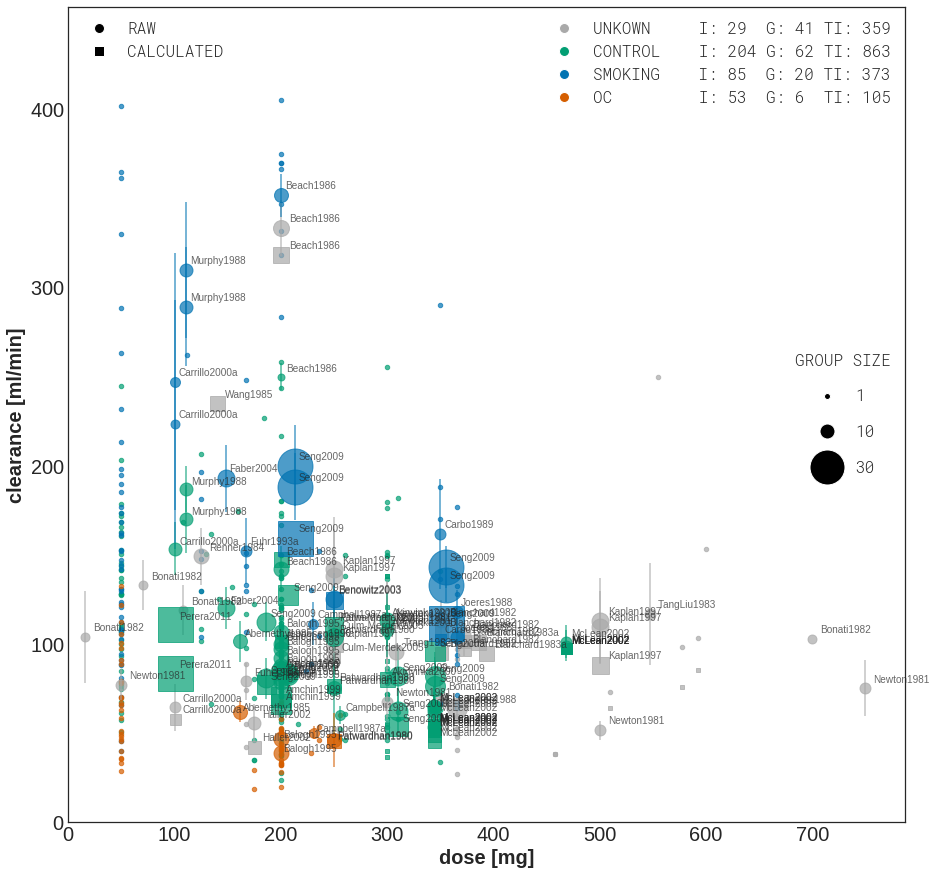

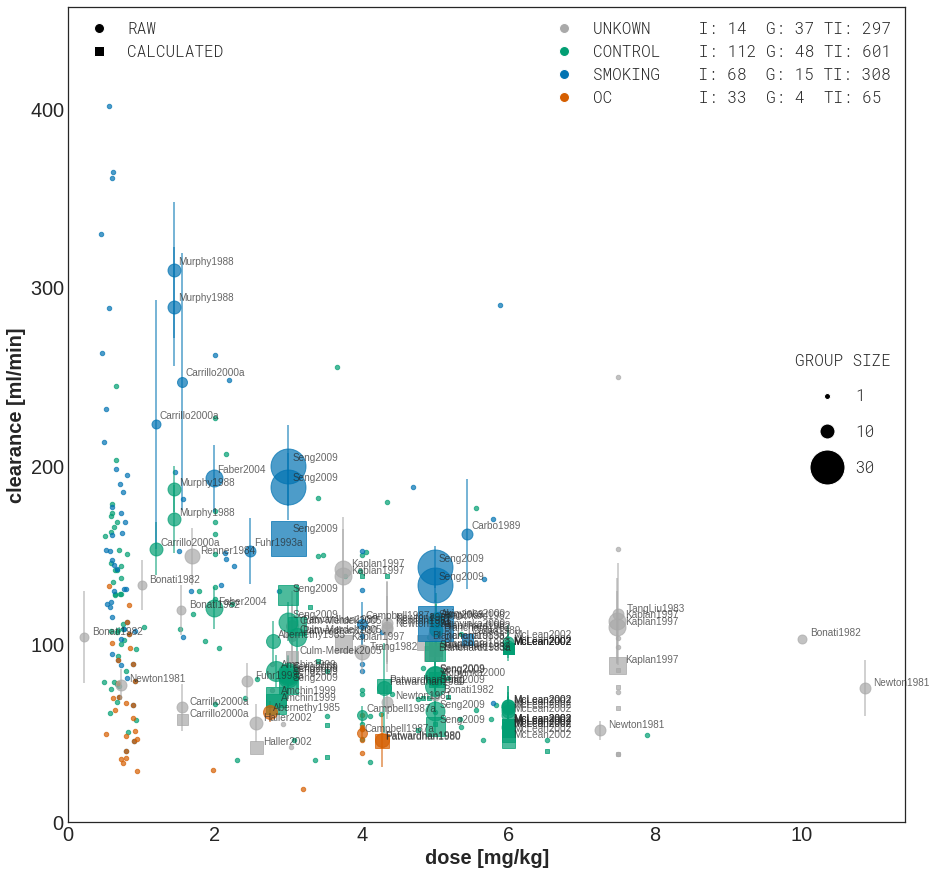

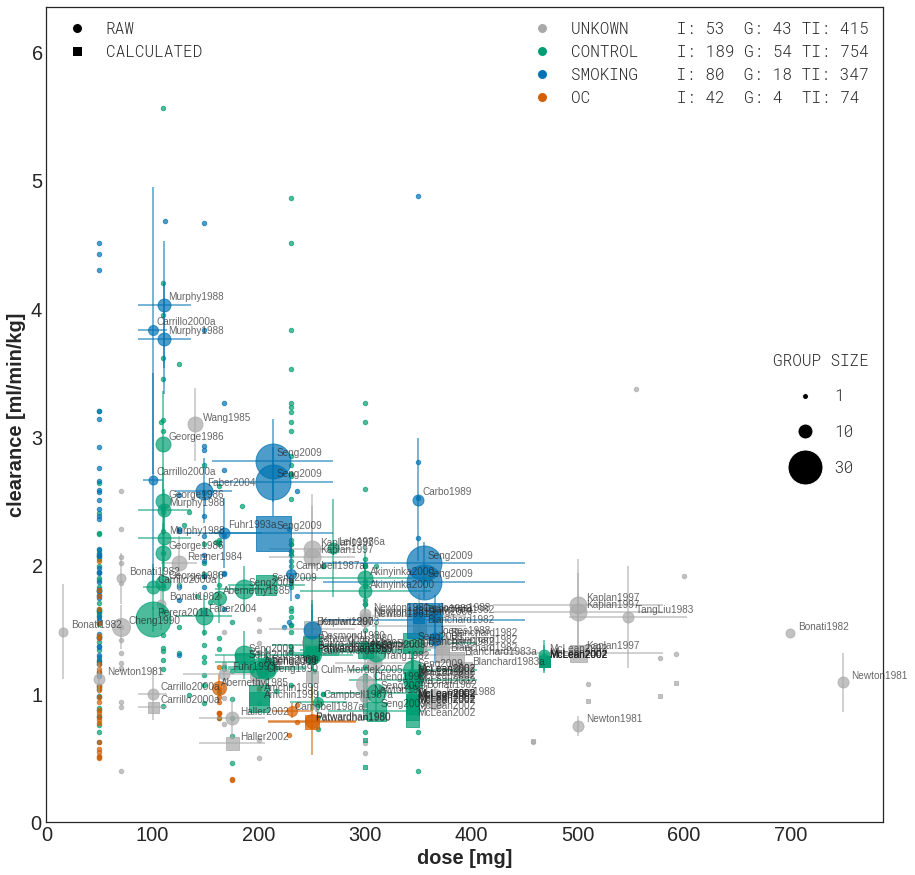

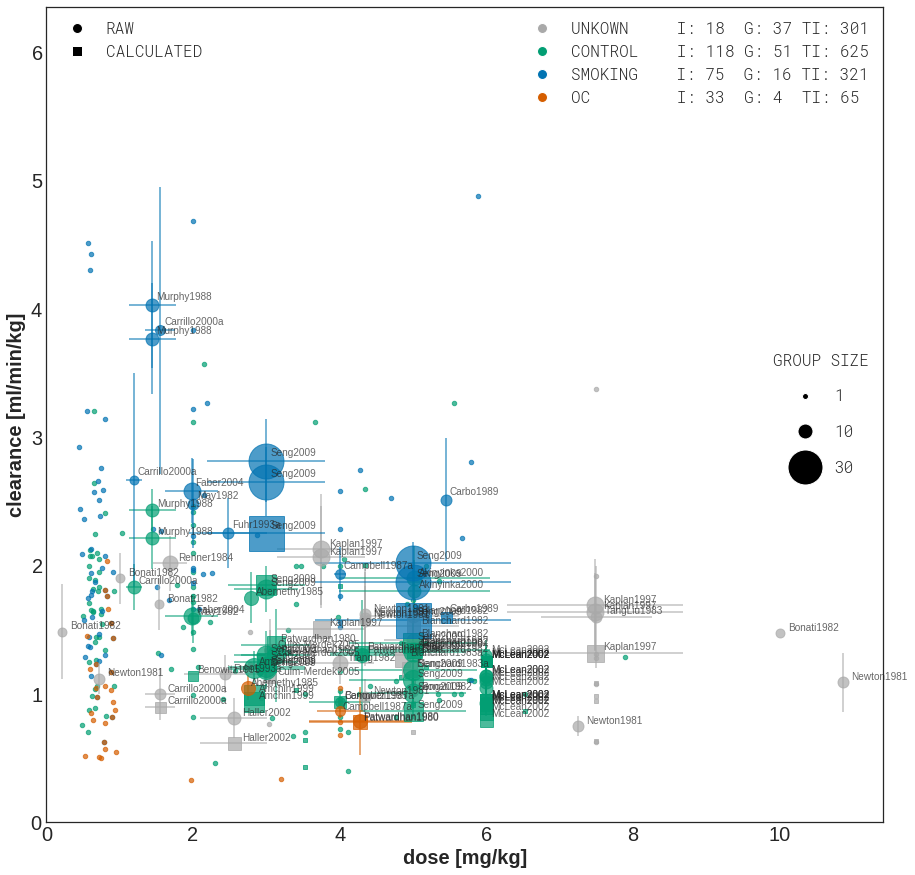

In [15]:
create_plots(caffeine_clearance,categories_soft,"reports/soft","clearance")

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 57  G: 52 TI: 472
CONTROL    I: 190 G: 56 TI: 803
SMOKING    I: 62  G: 15 TI: 311
OC         I: 44  G: 6  TI: 96 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 32  G: 45 TI: 381
CONTROL    I: 99  G: 43 TI: 544
SMOKING    I: 54  G: 12 TI: 272
OC         I: 24  G: 4  TI: 56 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 71  G: 52 TI: 507
CONTROL    I: 176 G: 49 TI: 697
SMOKING    I: 66  G: 14 TI: 303
OC         I: 33  G: 4  TI: 65 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 36  G: 45 TI: 385
CONTROL    I: 105 G: 46 TI: 568
SMOKING    I: 61  G: 13 TI: 285
OC         I: 24  G: 4  TI: 56 
OC-SMOKING I: 9   G: 0  TI: 9  


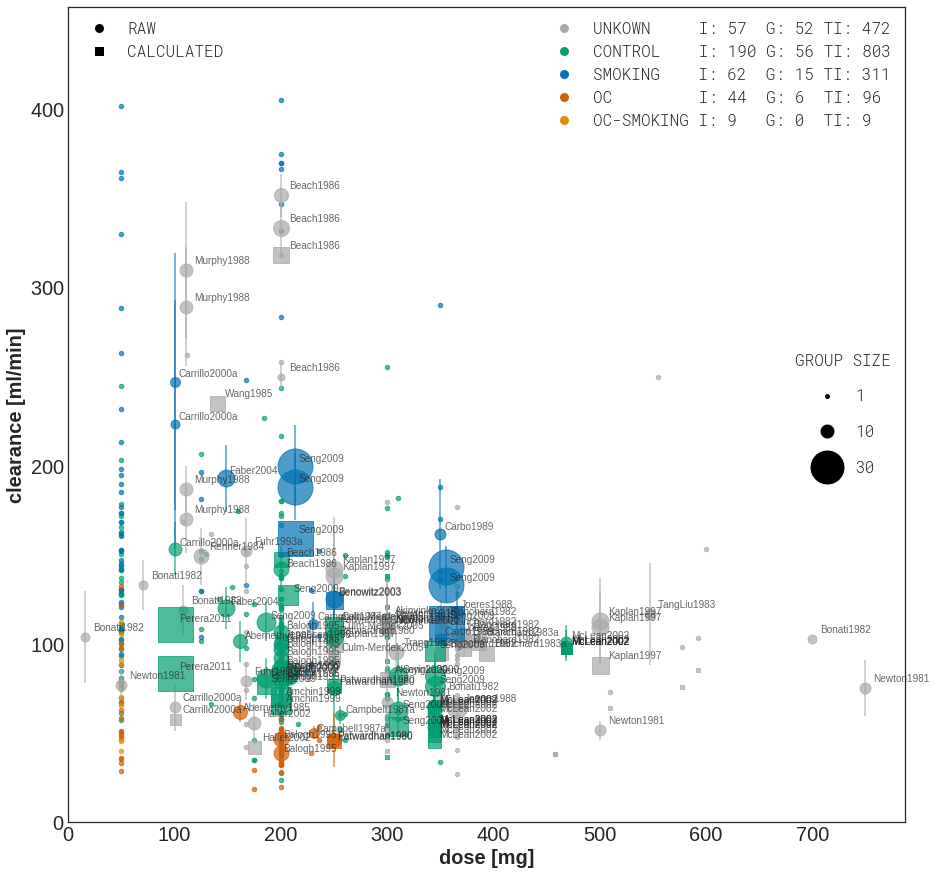

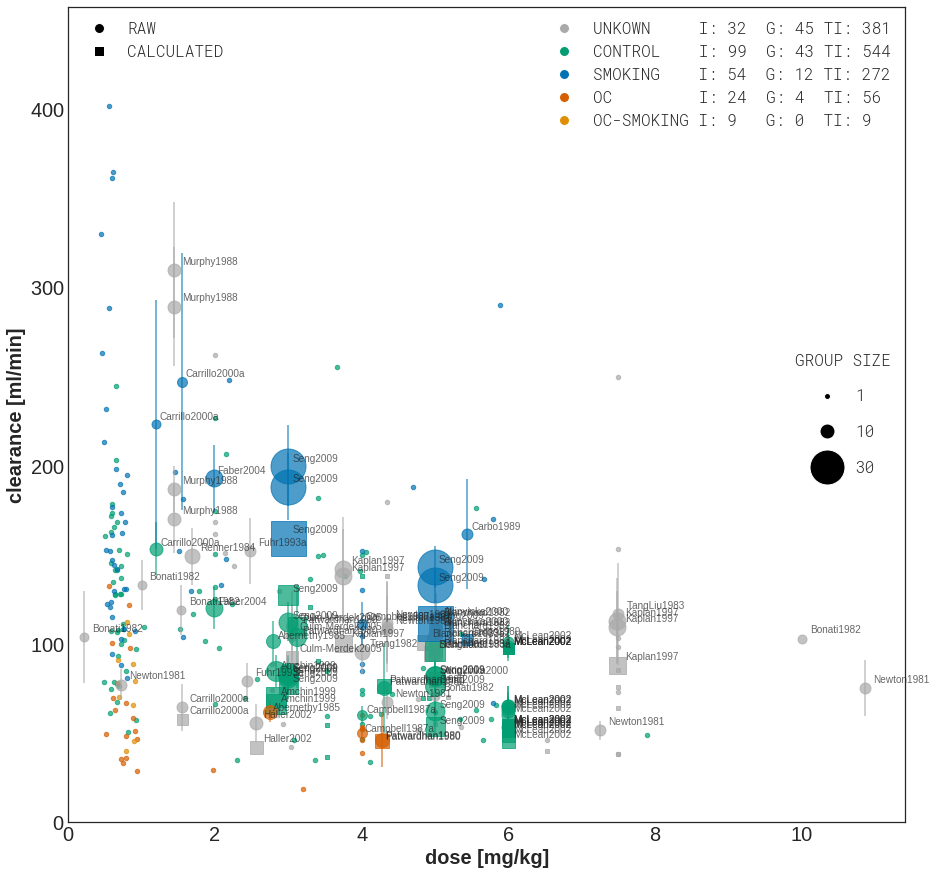

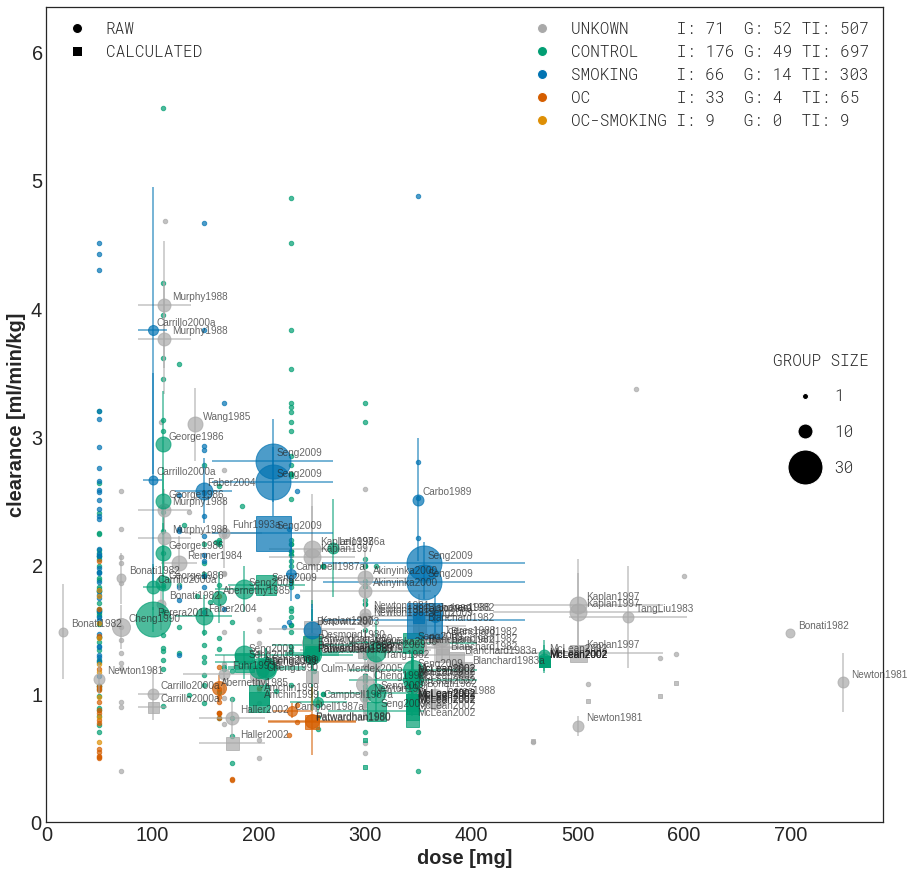

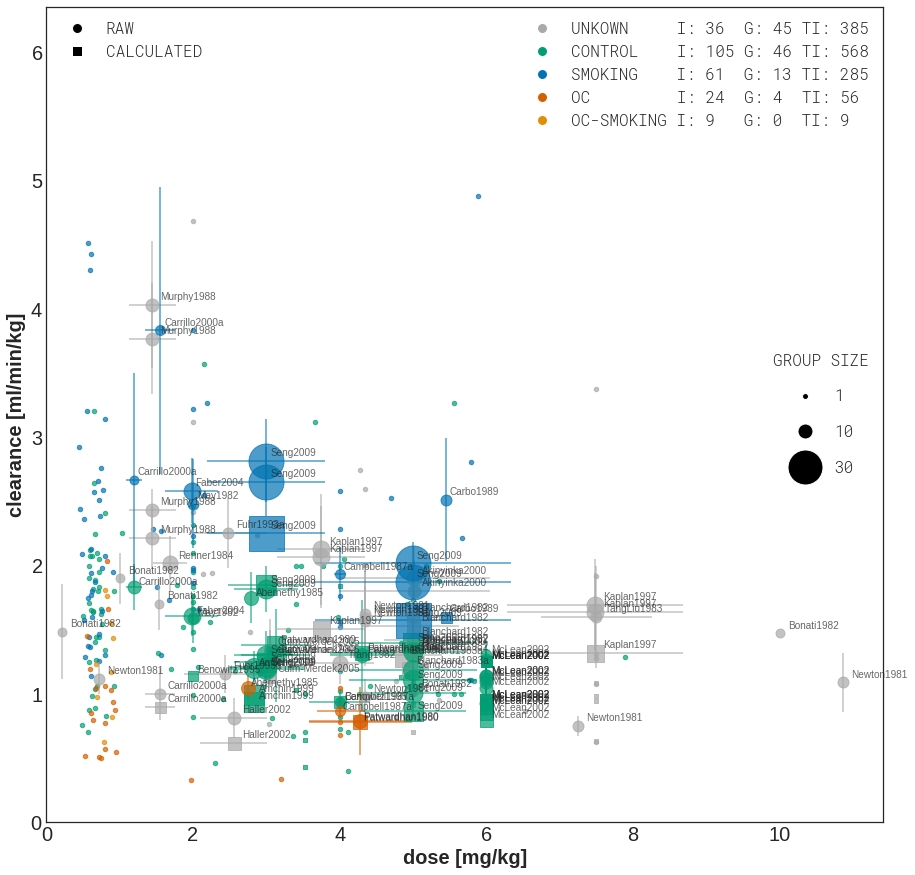

In [16]:
create_plots(caffeine_clearance,categories_strict,"reports/strict","clearance")

In [17]:
caffeine_clearance[abs_idx(caffeine_clearance,"unit_intervention") & abs_idx(caffeine_clearance,"unit")].groupby("subject_type").count()

study  output_type   pk  access  measurement_type  tissue  \
subject_type                                                              
group           140          140  140     140               140     140   
individual      434          434  434     434               434     434   

              allowed_users  substance  interventions  raw_pk  ...  \
subject_type                                                   ...   
group                   140        140            140     140  ...   
individual              434        434            434     434  ...   

              (cyp2d6 variant, count)  (lean body mass, count)  \
subject_type                                                     
group                               0                        0   
individual                          0                        0   

              (lean body mass, mean)  (lean body mass, sd)  \
subject_type                                                 
group                              0                     0   
individual                         0                     0   

              (lean body mass, unit)  (fat weight, count)  (fat weight, mean)  \
subject_type                                                                    
group                              0                   20                  20   
individual                         0                    0                   0   

              (fat weight, se)  (fat weight, unit)  outlier  
subject_type                                                 
group                       20                  20      140  
individual                   0                   0      434  

[2 rows x 239 columns]

In [18]:
caffeine_thf = PkdbModel("caffeine_thalf",destination="3-inferred")
caffeine_thf.read()
caffeine_thalf = caffeine_thf.data
caffeine_thalf["outlier"] = False
caffeine_thalf.loc[caffeine_thalf["study"]== "Balogh1992","outlier"] = True
caffeine_thalf.loc[caffeine_thalf["study"]== "Harder1988","outlier"] = True
caffeine_thalf.loc[caffeine_thalf["study"]== "Harder1989","outlier"] = True

In [19]:
caffeine_thalf.groupby(["calculated","outlier"]).get_group((True,False))[["study","value_intervention","unit_intervention","unit","value","mean"]]

study  value_intervention unit_intervention   unit  value  \
8       Akinyinka2000          300.000000                mg     hr    NaN   
30          Beach1986          200.000000                mg     hr    NaN   
114        Amchin1999          200.000000                mg     hr    NaN   
115        Amchin1999          200.000000                mg     hr    NaN   
117         Beach1986          200.000000                mg     hr    NaN   
119         Carbo1989          350.000000                mg     hr    NaN   
125      Benowitz2003          250.000000                mg     hr    NaN   
127     Carrillo2000a          100.000000                mg     hr    NaN   
136        Bonati1982            5.000000             mg/kg     hr   5.33   
137        Bonati1982            5.000000             mg/kg     hr   4.27   
138        Bonati1982            5.000000             mg/kg     hr   6.80   
139        Bonati1982            5.000000             mg/kg     hr   9.47   
141     Blanchard1982            5.000000             mg/kg     hr    NaN   
142     Blanchard1982            5.000000             mg/kg     hr    NaN   
144     Blanchard1982            5.000000             mg/kg     hr    NaN   
146     Blanchard1982            5.000000             mg/kg     hr    NaN   
163      Benowitz1995            4.000000             mg/kg     hr    NaN   
164      Benowitz1995            2.000000             mg/kg     hr    NaN   
171   Culm-Merdek2005          250.000000                mg     hr    NaN   
179        Haller2002          175.000000                mg     hr    NaN   
191    Blanchard1983a            4.850000             mg/kg     hr    NaN   
192    Blanchard1983a            4.940000             mg/kg     hr    NaN   
274      Jeppesen1996          200.000000                mg     hr    NaN   
278        McLean2002            6.000000             mg/kg     hr    NaN   
282        McLean2002            6.000000             mg/kg     hr    NaN   
283        McLean2002            6.000000             mg/kg     hr    NaN   
284        McLean2002            6.000000             mg/kg     hr    NaN   
285        McLean2002            6.000000             mg/kg     hr    NaN   
286        McLean2002            6.000000             mg/kg     hr    NaN   
288        McLean2002            6.000000             mg/kg     hr    NaN   
...               ...                 ...               ...    ...    ...   
1644       Haller2002            2.554745             mg/kg  hr/kg    NaN   
1657       Kaplan1997            3.742515             mg/kg  hr/kg    NaN   
1660       Kaplan1997            7.485030             mg/kg  hr/kg    NaN   
1664   Patwardhan1980            3.125000             mg/kg  hr/kg    NaN   
1667   Patwardhan1980            4.310345             mg/kg  hr/kg    NaN   
1669   Patwardhan1980            4.280822             mg/kg  hr/kg    NaN   
1686    Blanchard1982          351.000000                mg  hr/kg    NaN   
1687    Blanchard1982          351.000000                mg  hr/kg    NaN   
1689    Blanchard1982          372.000000                mg  hr/kg    NaN   
1691    Blanchard1982          372.000000                mg  hr/kg    NaN   
1695   Blanchard1983a          385.575000                mg  hr/kg    NaN   
1696   Blanchard1983a          392.730000                mg  hr/kg    NaN   
1699       McLean2002          344.400000                mg  hr/kg    NaN   
1703       McLean2002          344.400000                mg  hr/kg    NaN   
1704       McLean2002          344.400000                mg  hr/kg    NaN   
1705       McLean2002          344.400000                mg  hr/kg    NaN   
1706       McLean2002          344.400000                mg  hr/kg    NaN   
1707       McLean2002          344.400000                mg  hr/kg    NaN   
1709       McLean2002          344.400000                mg  hr/kg    NaN   
1710       McLean2002          344.400000                mg  hr/kg    NaN   
1711       M

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 34  G: 52 TI: 470
CONTROL    I: 175 G: 59 TI: 820
SMOKING    I: 62  G: 12 TI: 239
OC         I: 33  G: 6  TI: 85 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 36  G: 41 TI: 352
CONTROL    I: 105 G: 43 TI: 524
SMOKING    I: 61  G: 10 TI: 213
OC         I: 24  G: 4  TI: 56 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 32  G: 41 TI: 348
CONTROL    I: 99  G: 40 TI: 500
SMOKING    I: 54  G: 9  TI: 200
OC         I: 24  G: 4  TI: 56 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 32  G: 41 TI: 348
CONTROL    I: 99  G: 40 TI: 500
SMOKING    I: 54  G: 9  TI: 200
OC         I: 24  G: 4  TI: 56 
OC-SMOKING I: 9   G: 0  TI: 9  


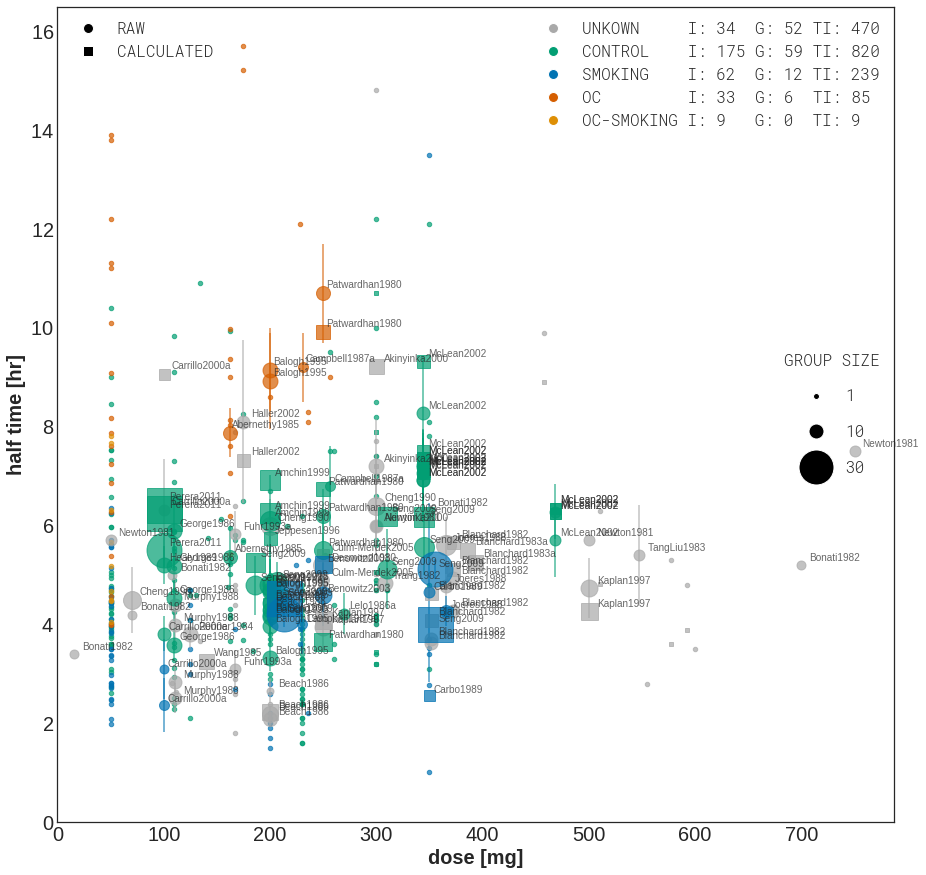

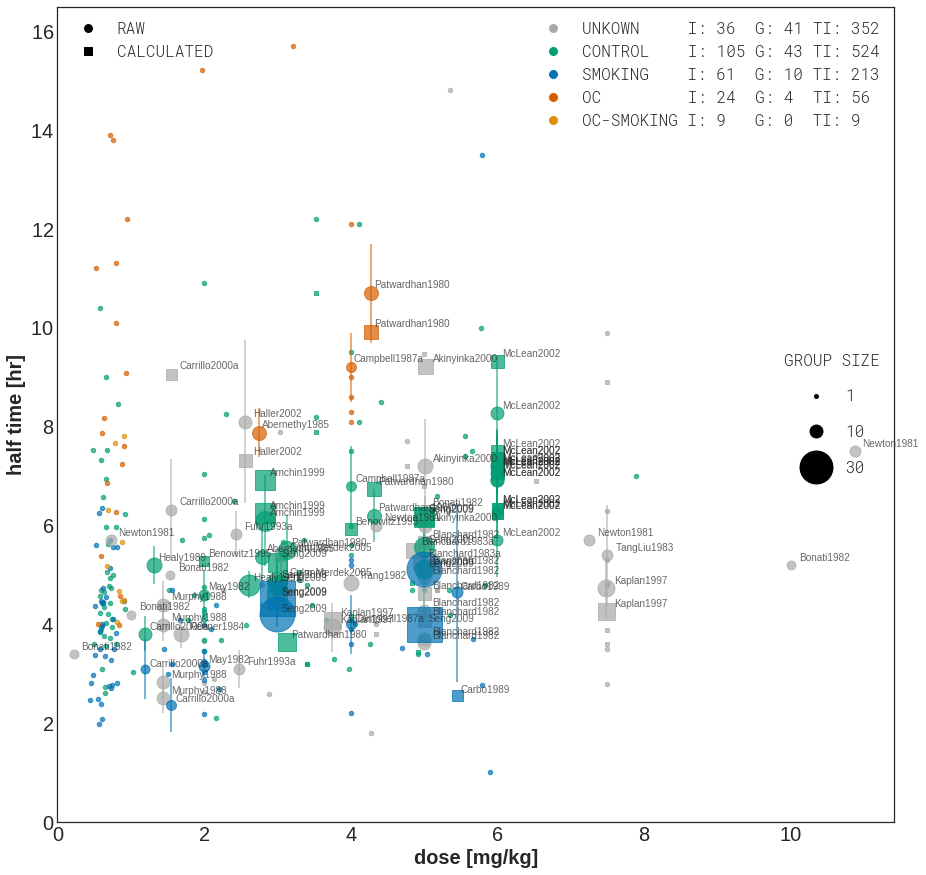

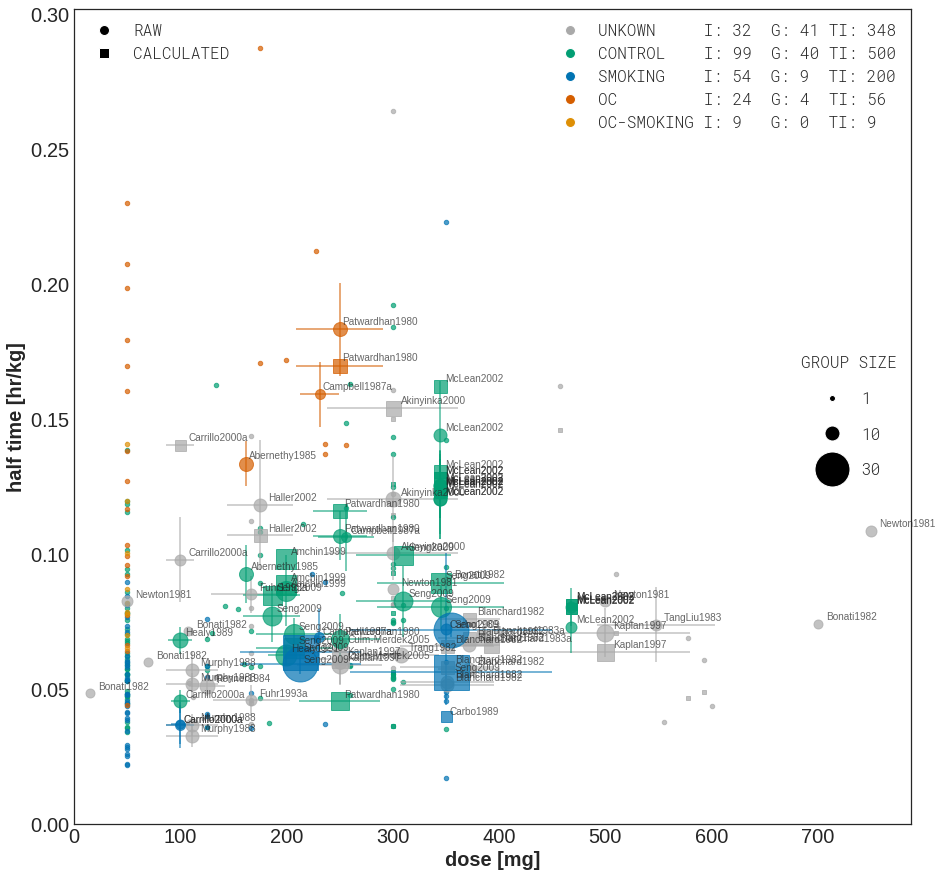

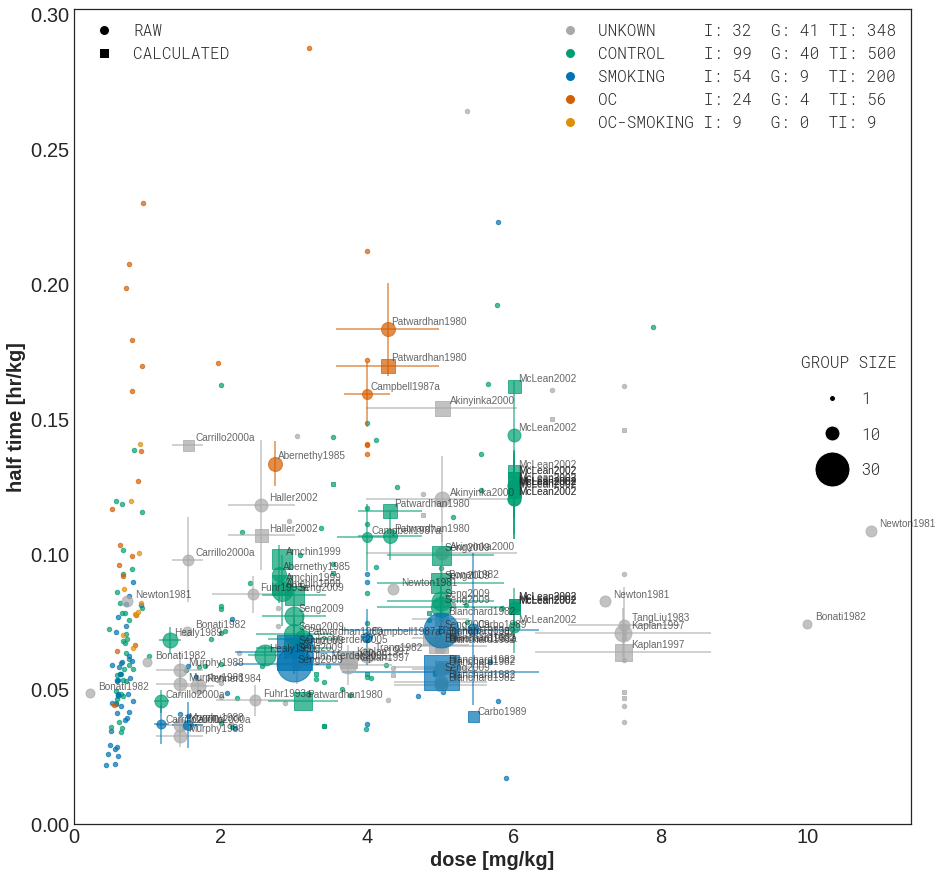

In [20]:
create_plots(caffeine_thalf,categories_strict,"reports/strict","thalf")

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 14  G: 41 TI: 365
CONTROL    I: 189 G: 65 TI: 880
SMOKING    I: 77  G: 17 TI: 293
OC         I: 42  G: 6  TI: 94 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 18  G: 33 TI: 268
CONTROL    I: 118 G: 48 TI: 581
SMOKING    I: 75  G: 13 TI: 249
OC         I: 33  G: 4  TI: 65 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 14  G: 33 TI: 264
CONTROL    I: 112 G: 45 TI: 557
SMOKING    I: 68  G: 12 TI: 236
OC         I: 33  G: 4  TI: 65 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 14  G: 33 TI: 264
CONTROL    I: 112 G: 45 TI: 557
SMOKING    I: 68  G: 12 TI: 236
OC         I: 33  G: 4  TI: 65 


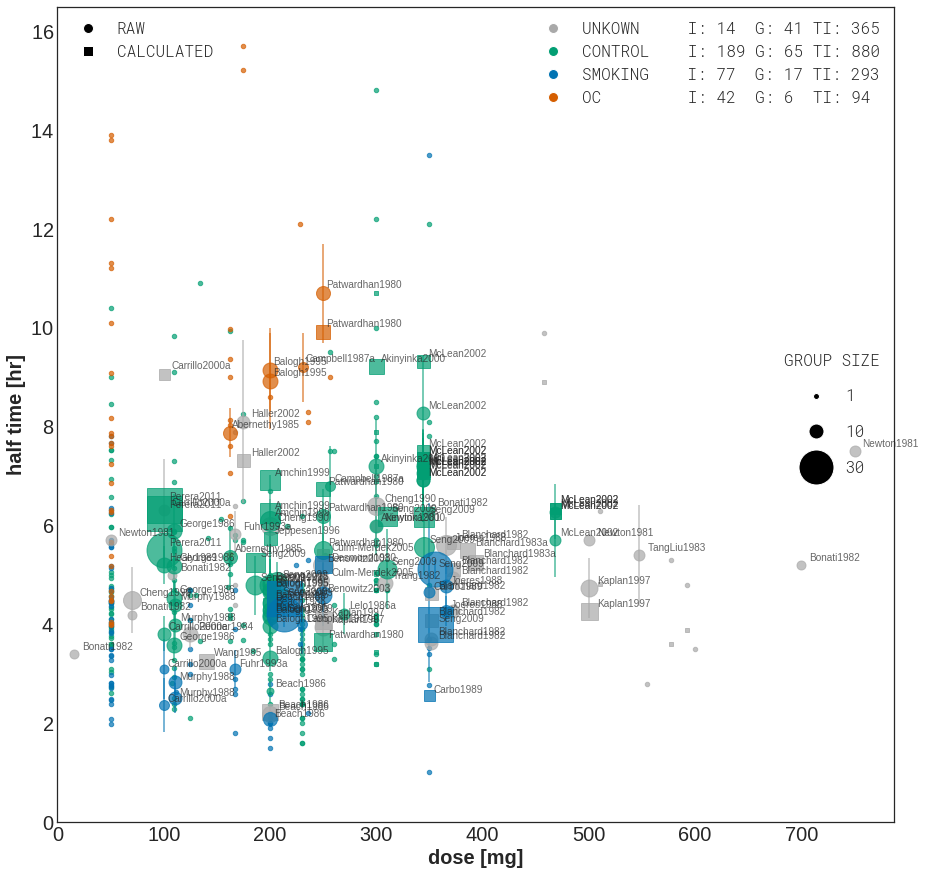

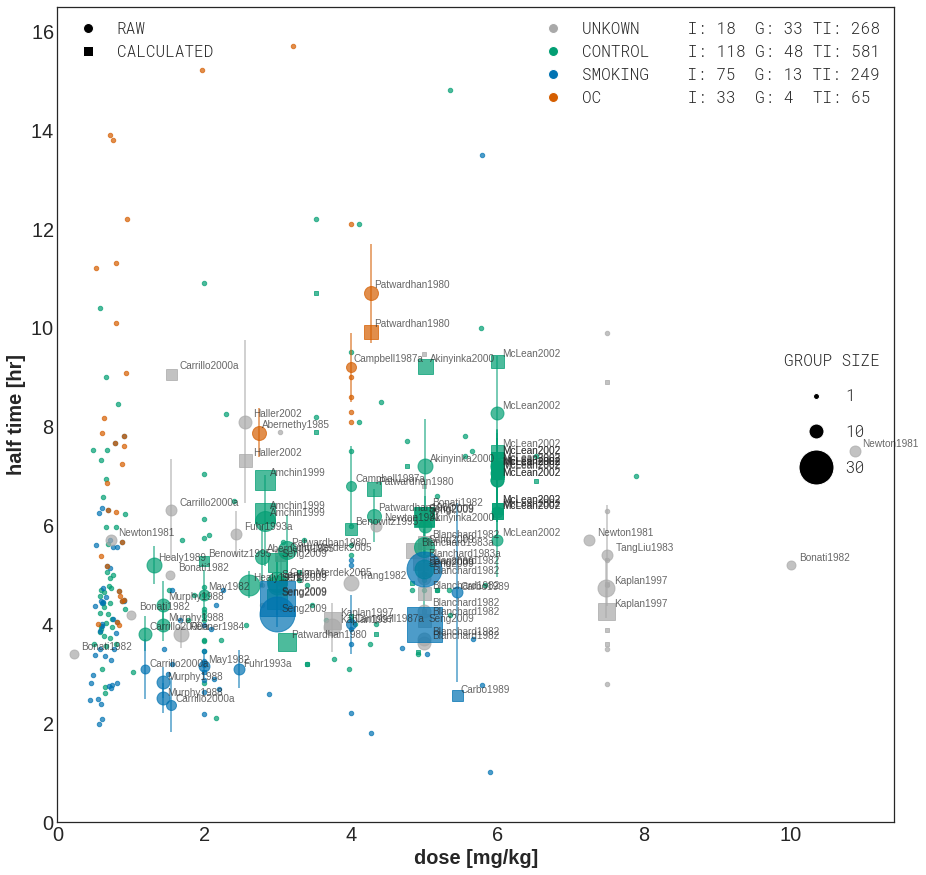

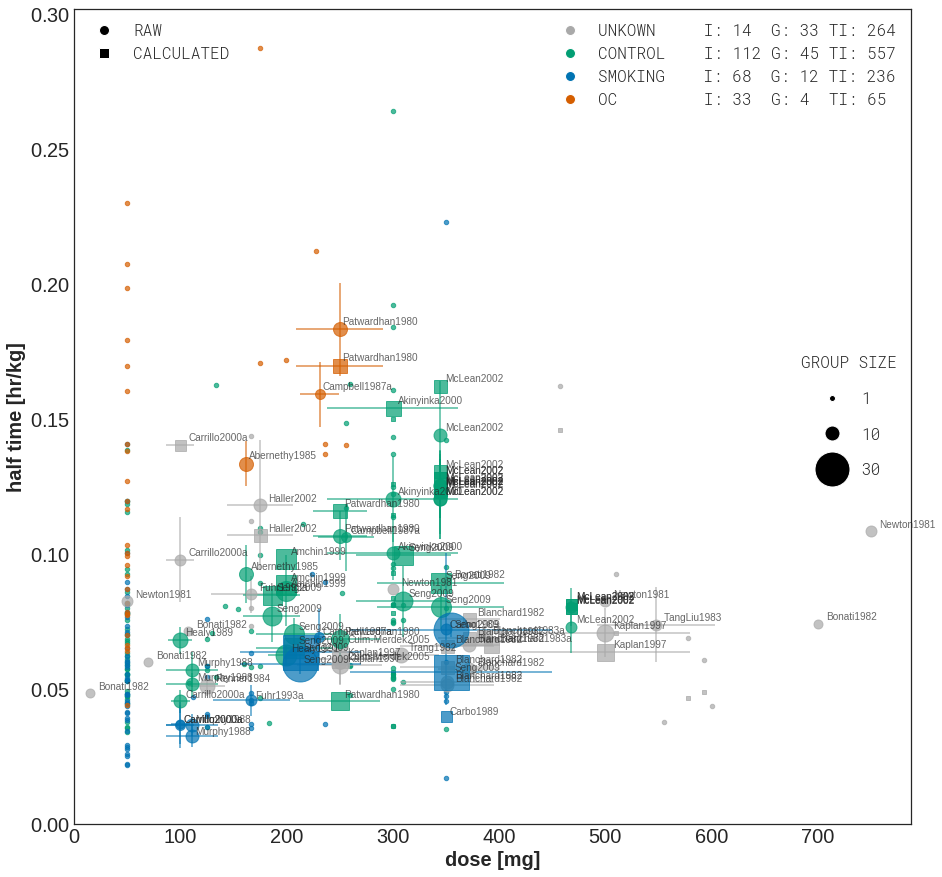

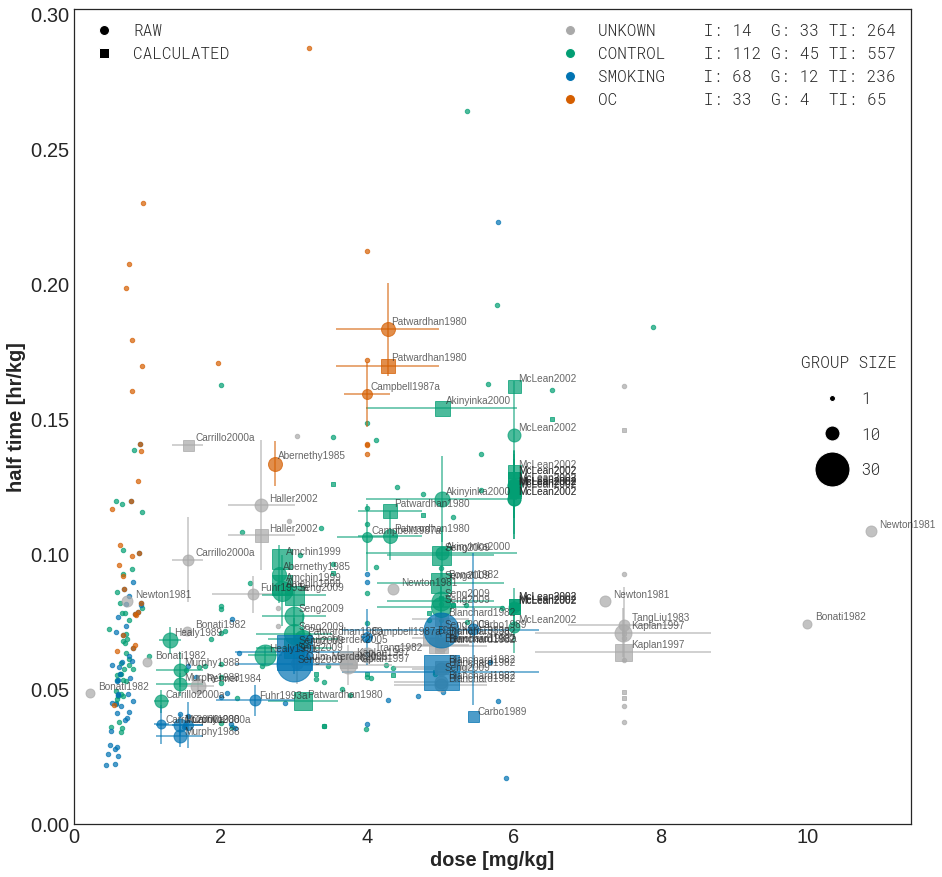

In [21]:
create_plots(caffeine_thalf,categories_soft,"reports/soft","thalf")

In [22]:
caffeine_mx = PkdbModel("caffeine_tmax",destination="3-inferred")
caffeine_mx.read()
caffeine_max = caffeine_mx.data
caffeine_max["outlier"] = False
caffeine_max.loc[caffeine_max["study"]== "Balogh1992","outlier"] = True
caffeine_max.loc[caffeine_max["study"]== "Harder1988","outlier"] = True
caffeine_max.loc[caffeine_max["study"]== "Harder1989","outlier"] = True


In [23]:
caffeine_max.groupby(["unit","unit_intervention"]).apply(len)

unit             unit_intervention
hour             gram                 261
                 gram / kilogram      199
hour / kilogram  gram                 178
                 gram / kilogram      178
dtype: int64

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 11  G: 27 TI: 250
CONTROL    I: 62  G: 50 TI: 630
SMOKING    I: 14  G: 10 TI: 128
OC         I: 2   G: 4  TI: 40 
OC-SMOKING I: 0   G: 0  TI: 0  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 13  G: 22 TI: 209
CONTROL    I: 19  G: 38 TI: 377
SMOKING    I: 13  G: 9  TI: 109
OC         I: 2   G: 2  TI: 20 
OC-SMOKING I: 0   G: 0  TI: 0  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 9   G: 22 TI: 205
CONTROL    I: 13  G: 35 TI: 353
SMOKING    I: 6   G: 8  TI: 96 
OC         I: 2   G: 2  TI: 20 
OC-SMOKING I: 0   G: 0  TI: 0  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 9   G: 22 TI: 205
CONTROL    I: 13  G: 35 TI: 353
SMOKING    I: 6   G: 8  TI: 96 
OC         I: 2   G: 2  TI: 20 
OC-SMOKING I: 0   G: 0  TI: 0  


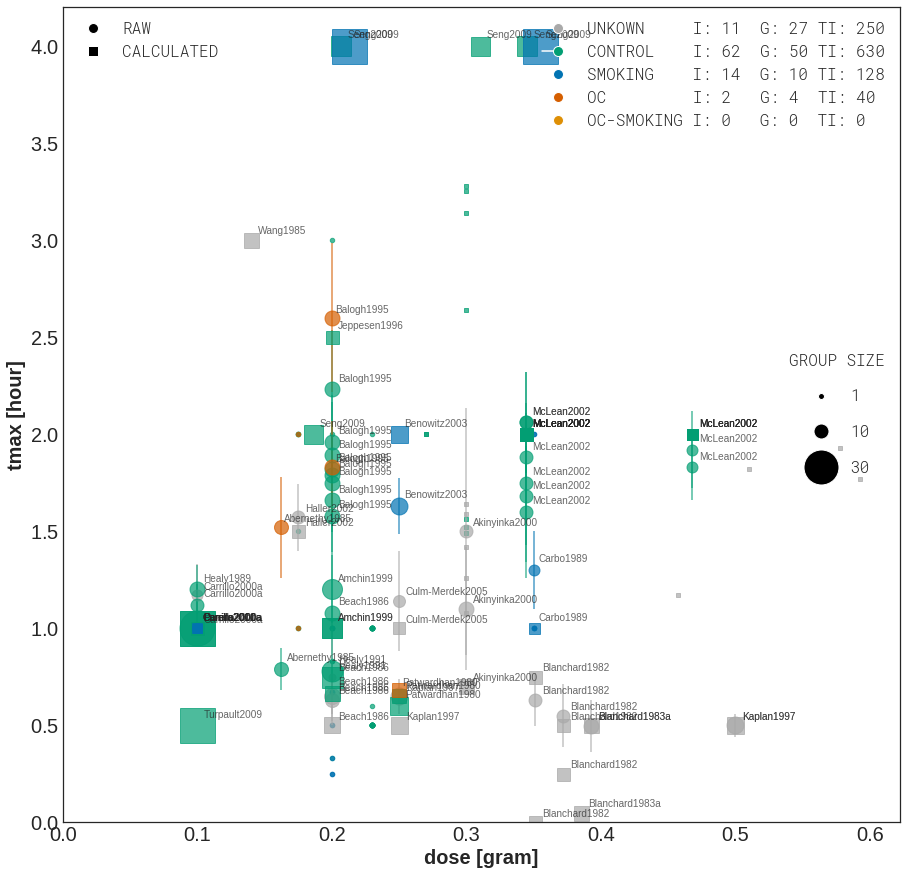

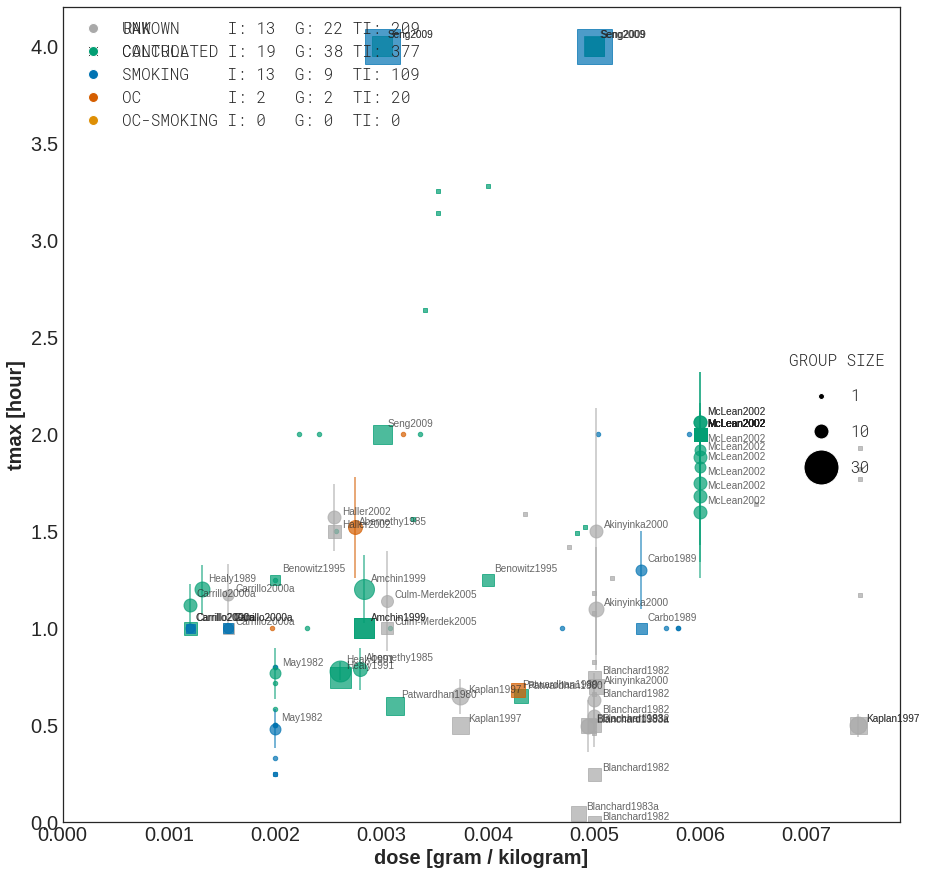

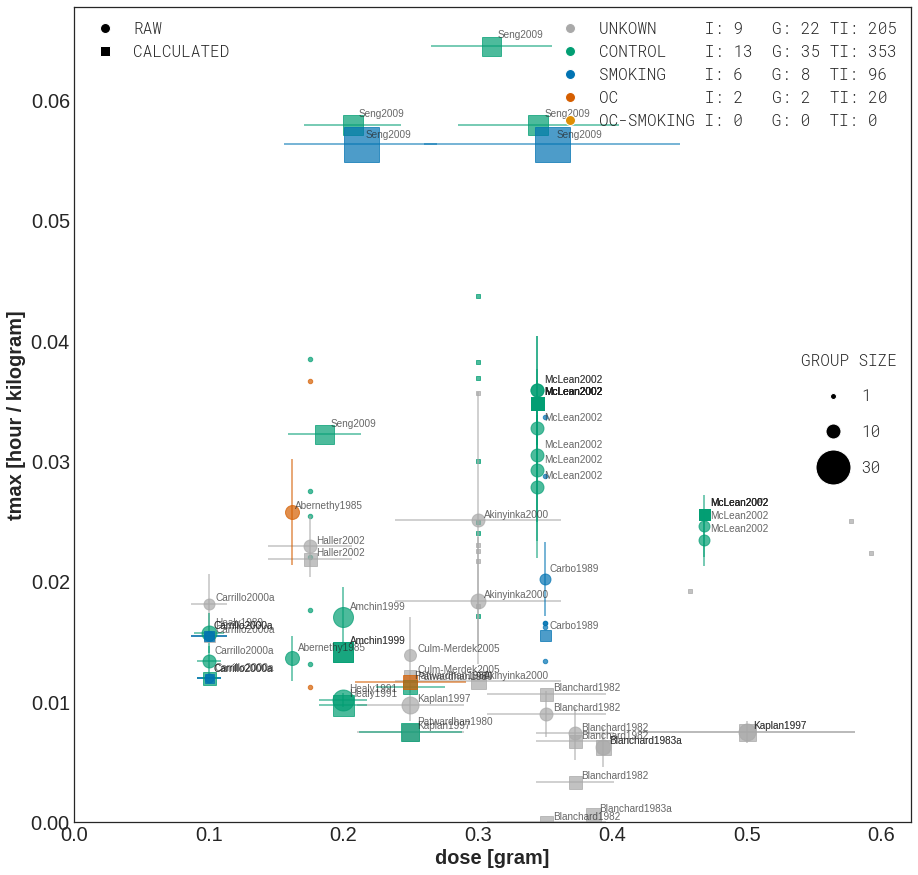

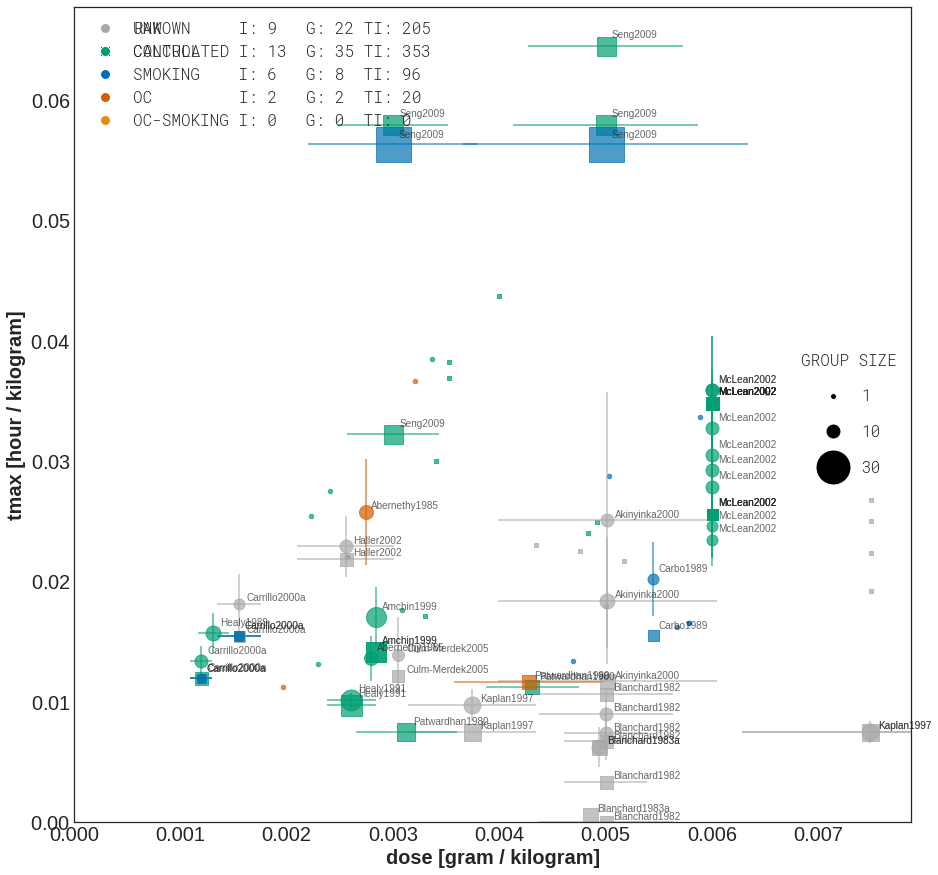

In [24]:
create_plots(caffeine_max,categories_strict,"reports/strict","tmax")

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 4   G: 22 TI: 204
CONTROL    I: 68  G: 54 TI: 666
SMOKING    I: 15  G: 11 TI: 138
OC         I: 2   G: 4  TI: 40 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 8   G: 19 TI: 176
CONTROL    I: 24  G: 41 TI: 410
SMOKING    I: 13  G: 9  TI: 109
OC         I: 2   G: 2  TI: 20 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 4   G: 19 TI: 172
CONTROL    I: 18  G: 38 TI: 386
SMOKING    I: 6   G: 8  TI: 96 
OC         I: 2   G: 2  TI: 20 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 4   G: 19 TI: 172
CONTROL    I: 18  G: 38 TI: 386
SMOKING    I: 6   G: 8  TI: 96 
OC         I: 2   G: 2  TI: 20 


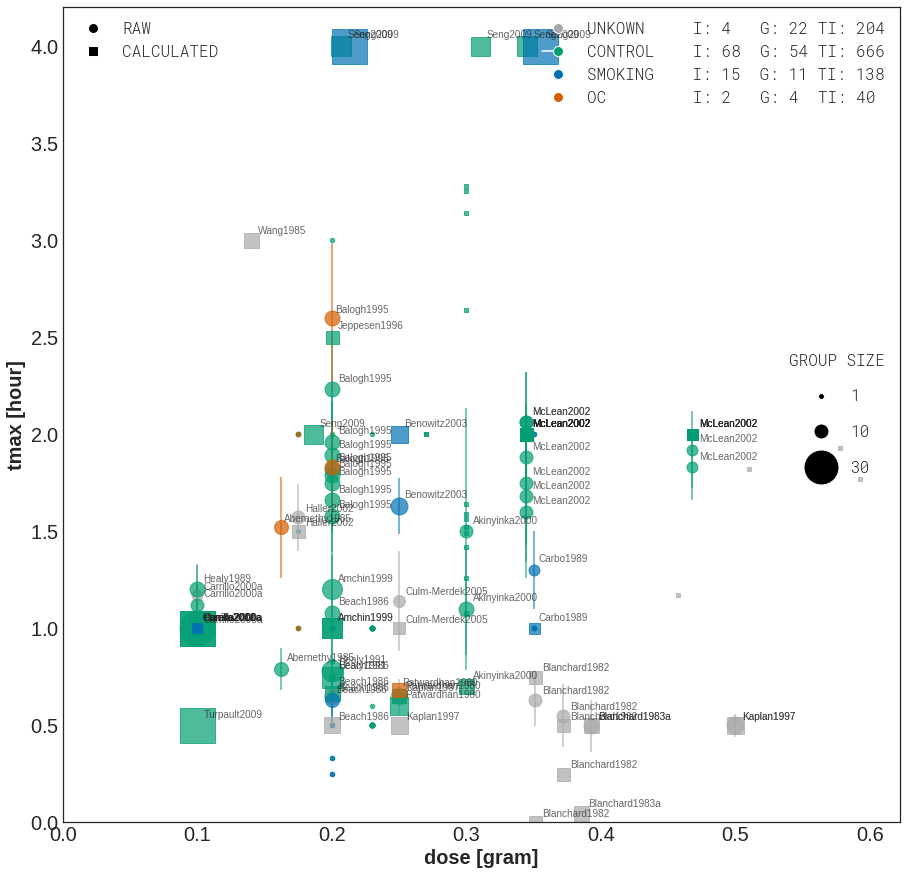

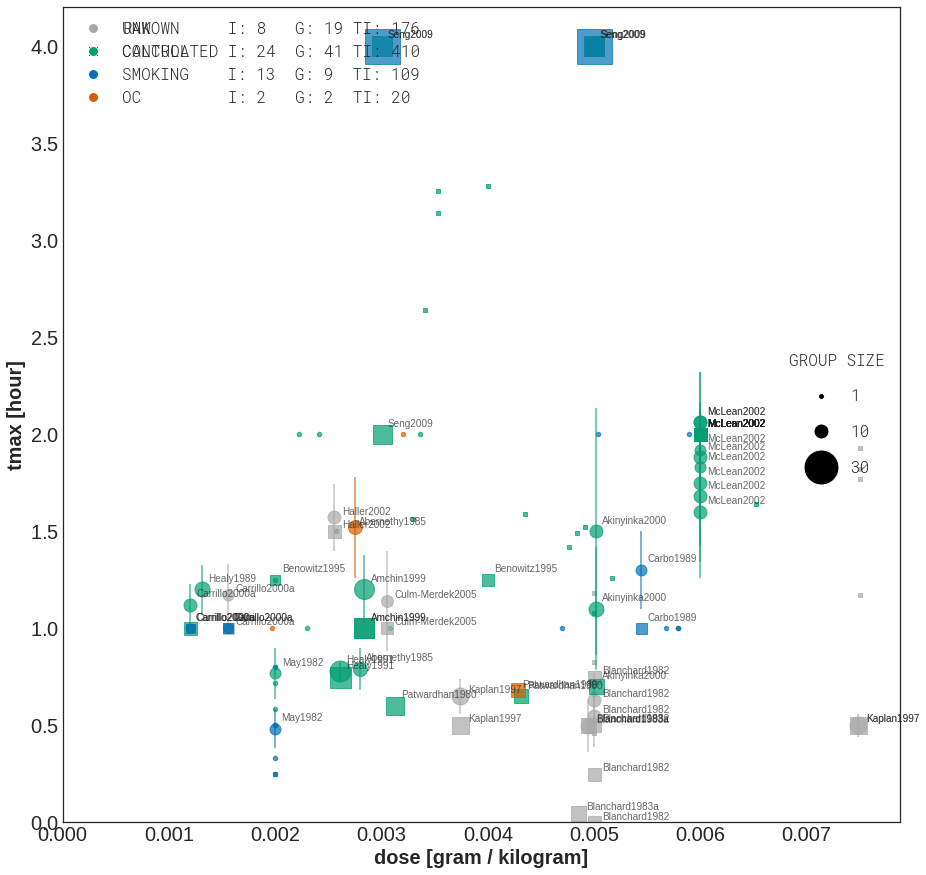

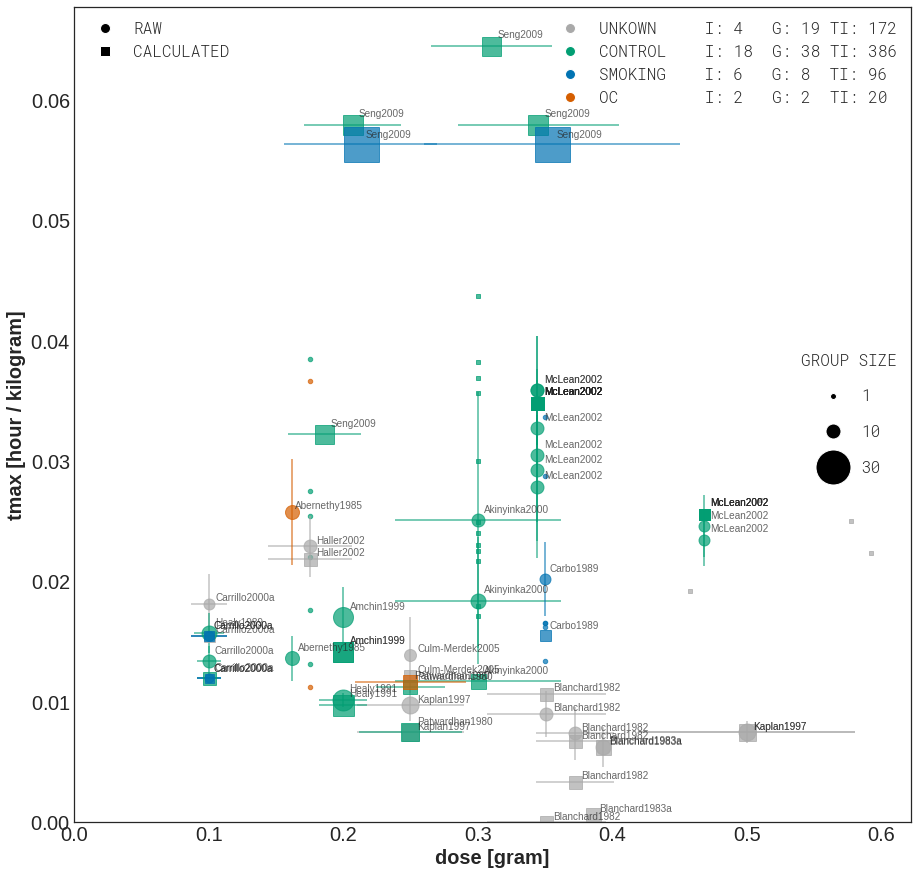

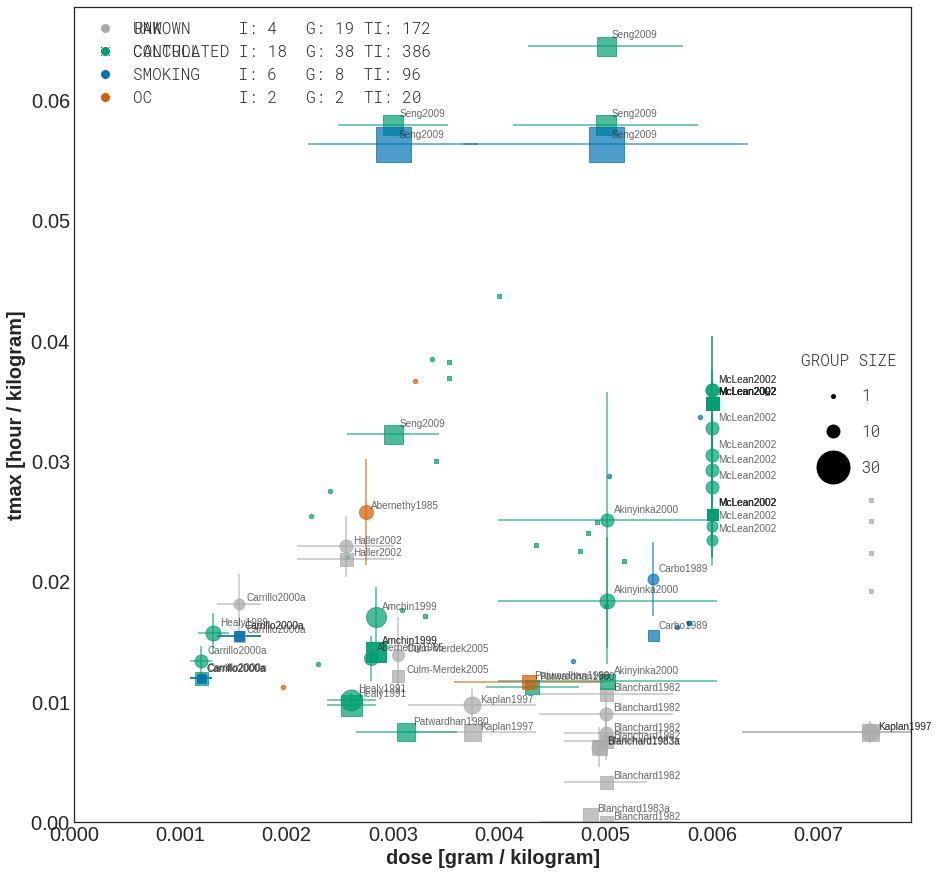

In [25]:
create_plots(caffeine_max,categories_soft,"reports/soft","tmax")

In [26]:
caffeine_instance = PkdbModel("caffeine_vd",destination="3-inferred")
caffeine_instance.read()
caffeine_instance_data = caffeine_instance.data
caffeine_instance_data["outlier"] = False
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Balogh1992","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1988","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1989","outlier"] = True

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 33  G: 46 TI: 398
CONTROL    I: 96  G: 56 TI: 709
SMOKING    I: 57  G: 11 TI: 247
OC         I: 19  G: 6  TI: 75 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 31  G: 39 TI: 330
CONTROL    I: 85  G: 43 TI: 530
SMOKING    I: 49  G: 9  TI: 220
OC         I: 19  G: 4  TI: 55 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 31  G: 46 TI: 417
CONTROL    I: 130 G: 48 TI: 621
SMOKING    I: 49  G: 10 TI: 227
OC         I: 28  G: 4  TI: 64 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 35  G: 39 TI: 334
CONTROL    I: 91  G: 46 TI: 554
SMOKING    I: 56  G: 10 TI: 233
OC         I: 19  G: 4  TI: 55 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 14  G: 41 TI: 344
CONTROL    I: 109 G: 58 TI: 734
SMOKING    I: 72  G: 14 TI: 285
OC         I: 28  G: 6  TI: 84 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 14  G: 37 TI: 297
CONTROL    I: 97  G: 44 TI: 552
SMOKING    I: 63  G: 10 TI: 240
OC         I: 28  G: 4  TI: 64 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 14  G: 43 TI: 376
CONTROL    I: 142 G: 49 TI: 643
SMOKING    I: 63  G: 12 TI: 255
OC         I: 37  G: 4  TI: 73 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 18  G: 37 TI: 301
CONTROL    I: 103 G: 47 TI: 576
SMOKING    I: 70  G: 11 TI: 253
OC         I: 28  G: 4  TI: 64 


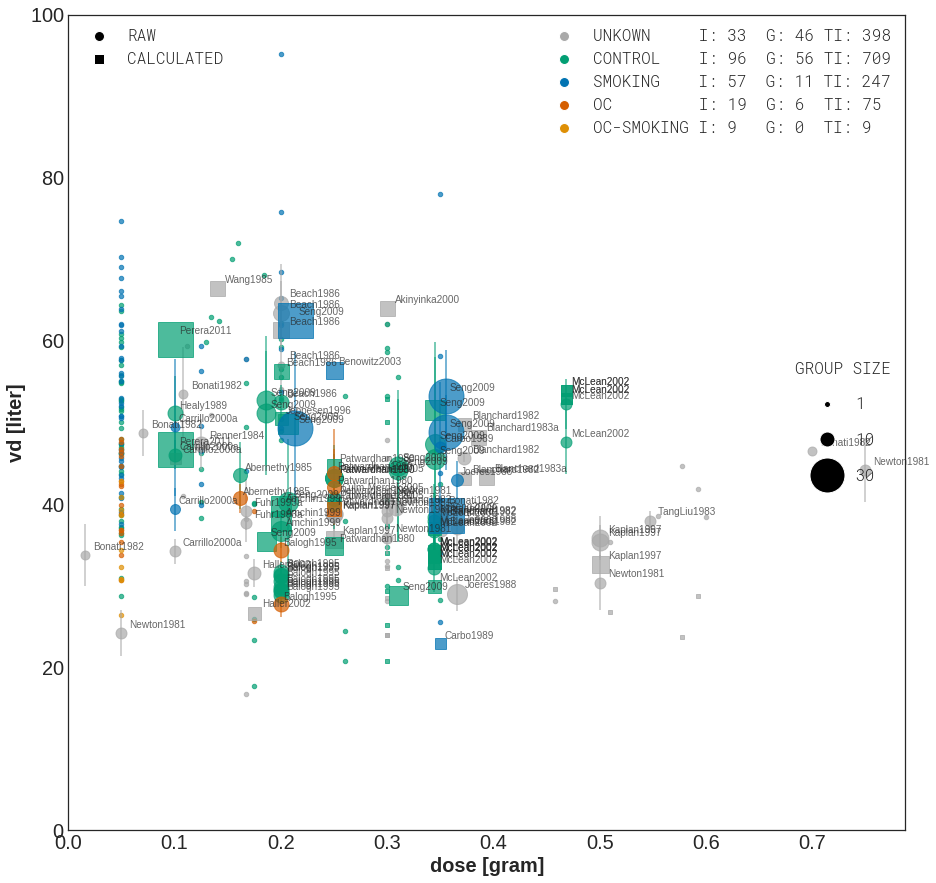

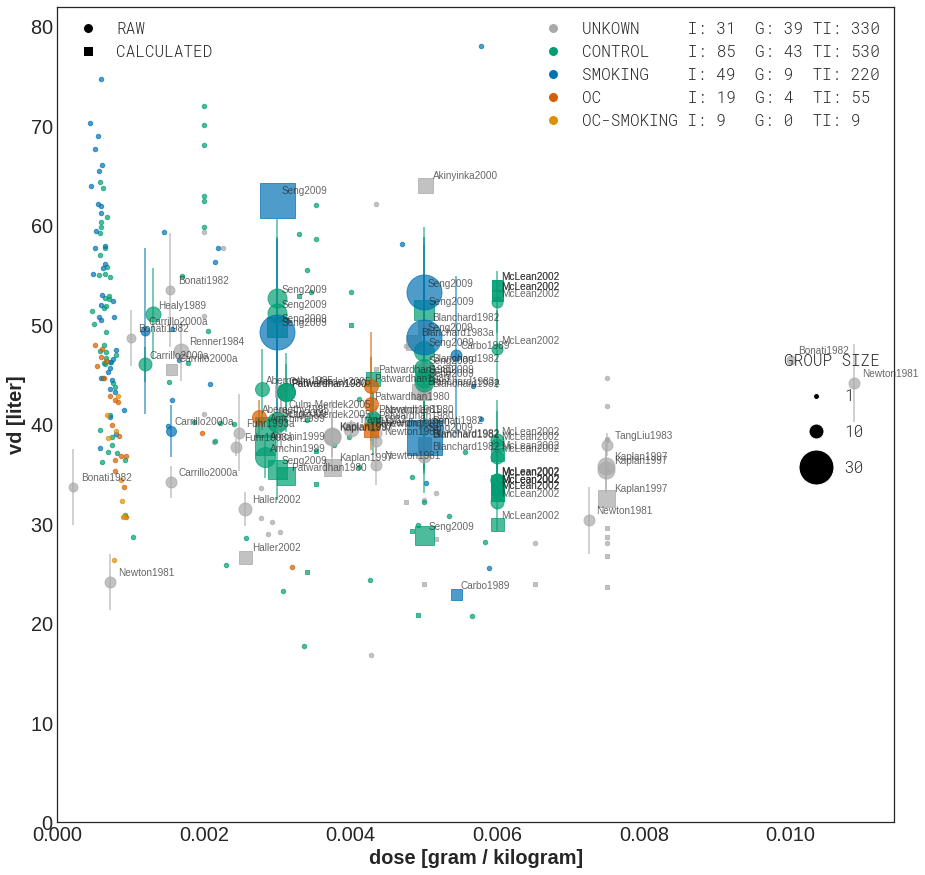

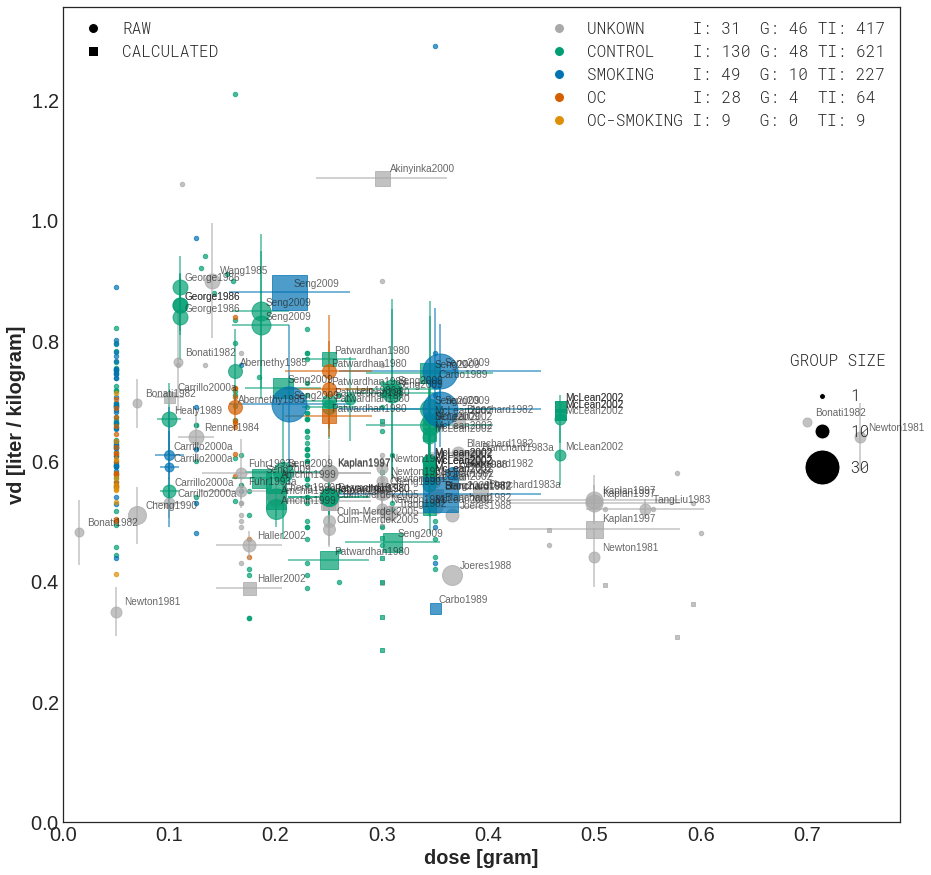

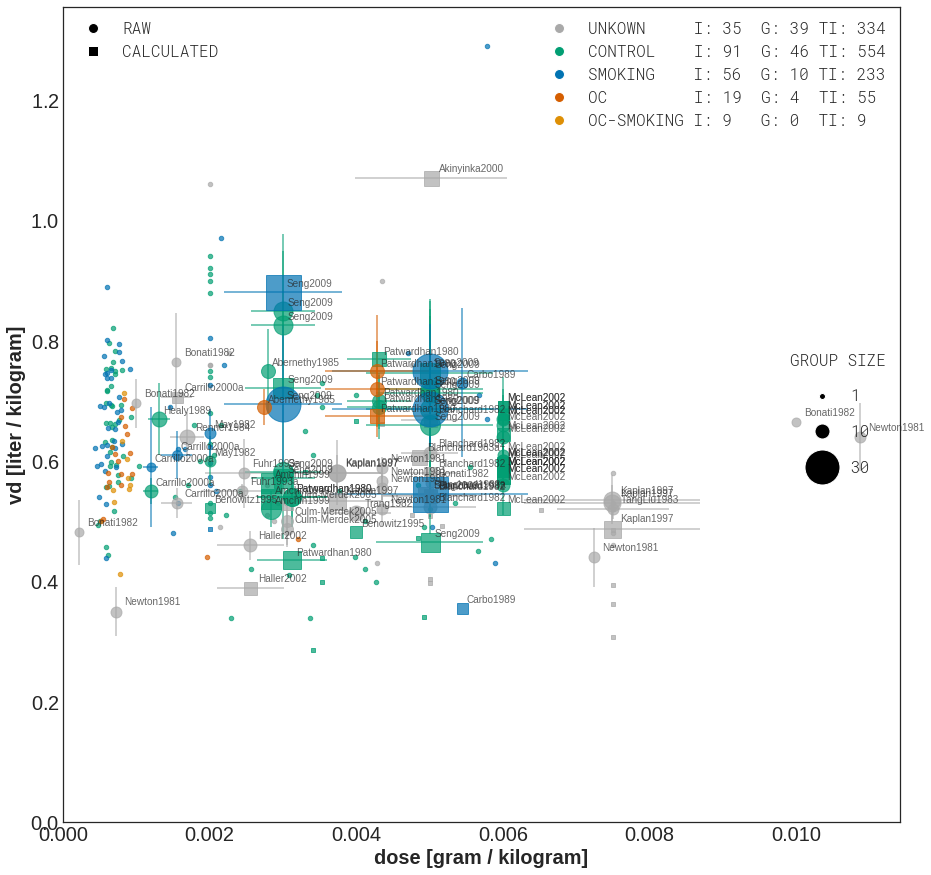

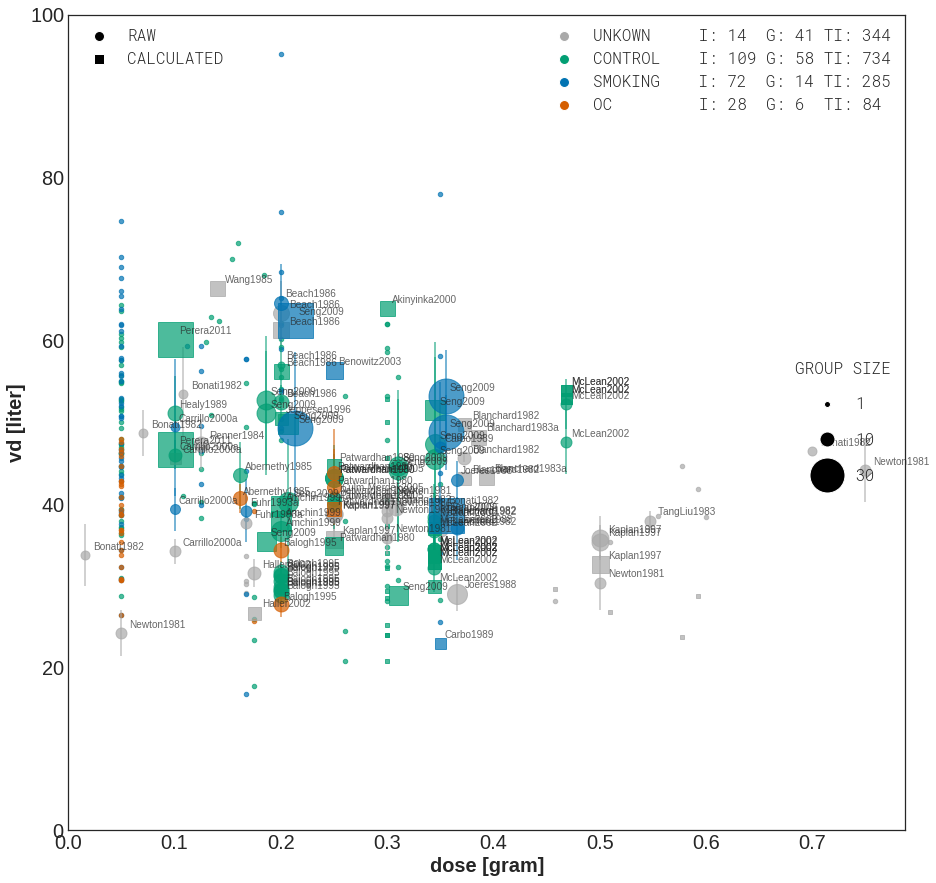

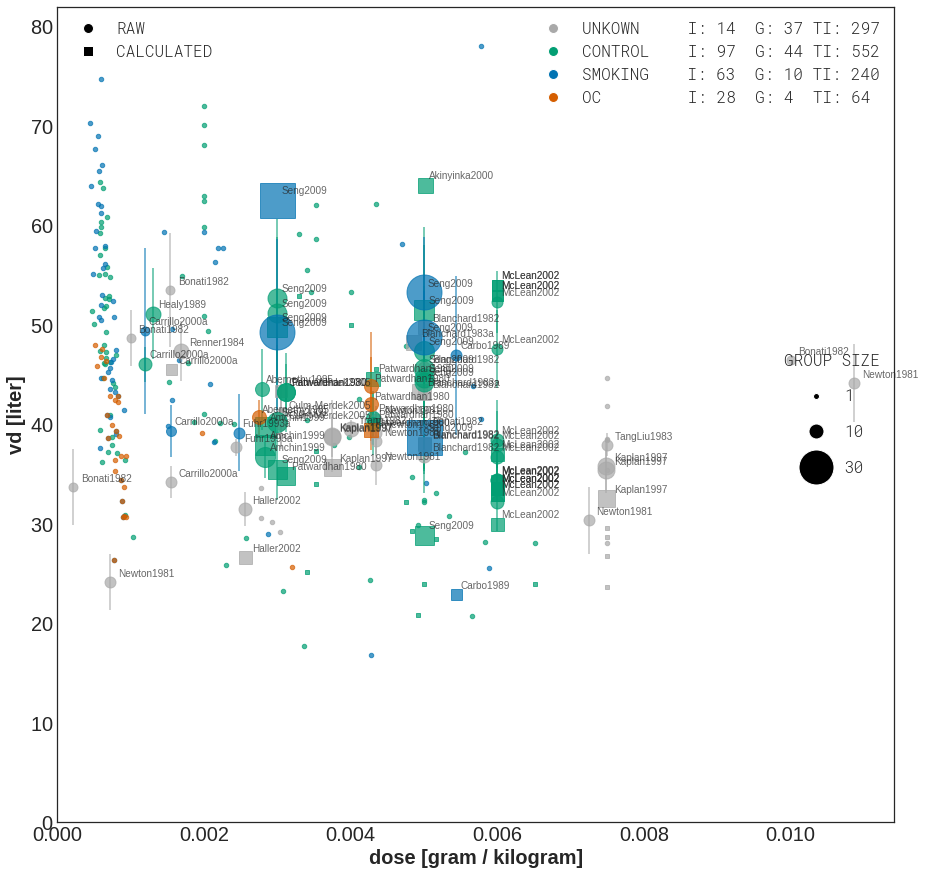

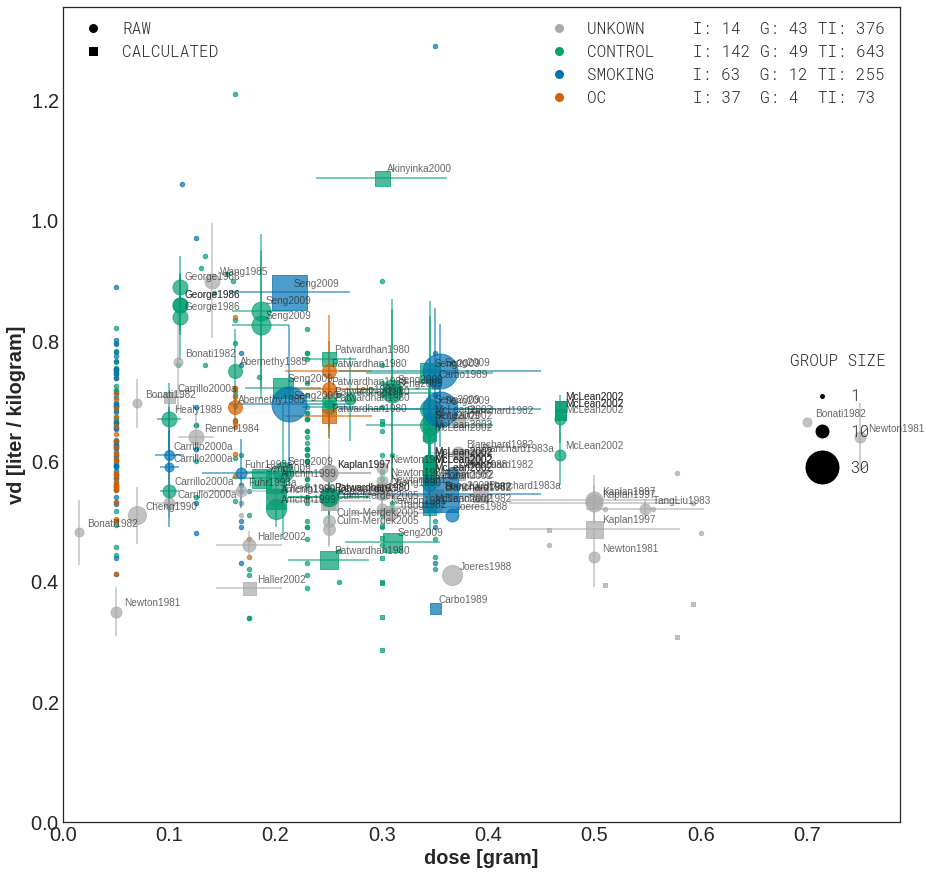

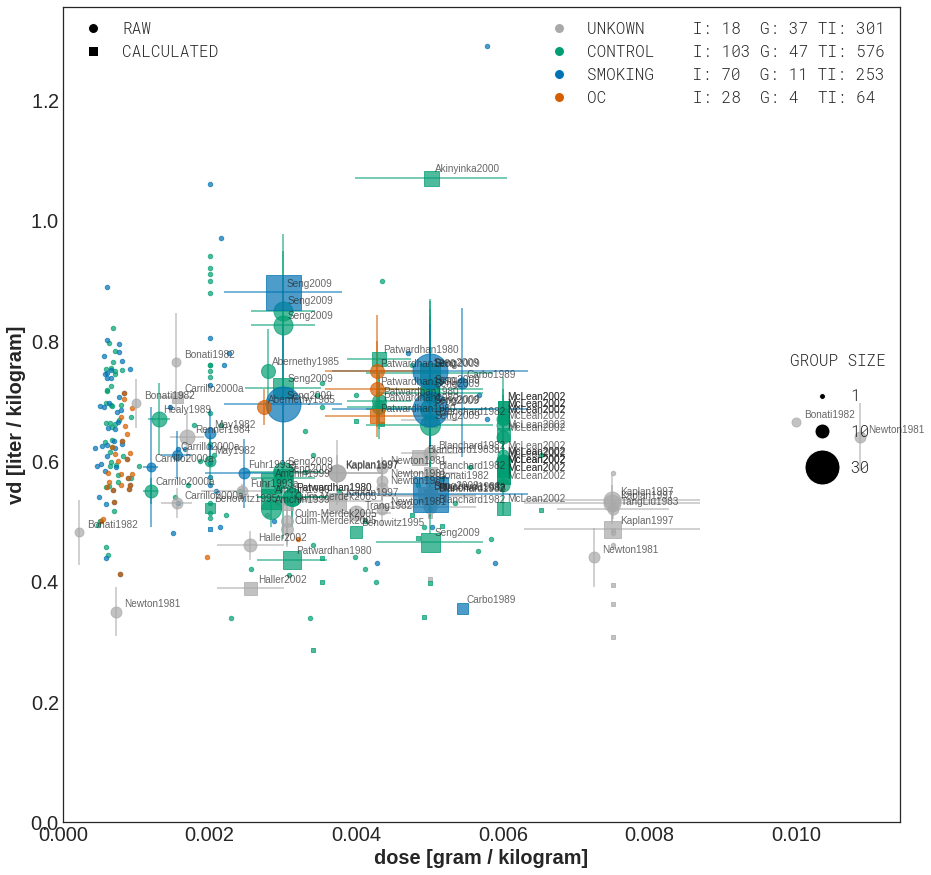

In [27]:
create_plots(caffeine_instance_data,categories_strict,"reports/strict","vd")
create_plots(caffeine_instance_data,categories_soft,"reports/soft","vd")

In [28]:
caffeine_instance = PkdbModel("caffeine_auc_inf",destination="3-inferred")
caffeine_instance.read()
caffeine_instance_data = caffeine_instance.data
caffeine_instance_data["outlier"] = False
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Balogh1992","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1988","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1989","outlier"] = True
#caffeine_instance_data.dropna(subset=["value"], inplace=True)

In [29]:
caffeine_instance_data["mean"].dropna()

7      0.062200
8      0.055600
9      0.051900
10     0.009950
11     0.044500
12     0.047200
13     0.048700
14     0.022000
15     0.044100
16     0.043600
21     0.031200
22     0.026400
23     0.026400
24     0.009690
25     0.012600
26     0.009440
31     0.056700
32     0.061400
33     0.056700
34     0.059200
35     0.062300
36     0.061900
37     0.065200
38     0.064500
39     0.068400
40     0.027600
47     0.048000
48     0.066000
49     0.069000
50     0.069100
         ...   
498    0.002003
499    0.001713
500    0.001713
501    0.001713
502    0.002021
503    0.001794
504    0.001740
505    0.002021
506    0.001740
507    0.002073
508    0.001951
509    0.001829
510    0.001829
511    0.000931
512    0.001045
513    0.001055
514    0.000931
515    0.000584
516    0.001355
517    0.000576
518    0.000270
519    0.001266
520    0.000565
521    0.000329
522    0.000810
523    0.000494
524    0.001024
525    0.001598
526    0.000561
527    0.000276
Name: mean, Length: 146,

In [30]:
#intermediate = caffeine_instance_data[(caffeine_instance_data["value"].isna() == False)]
#intermediate[intermediate["calculated"]==True]

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 19  G: 13 TI: 131
CONTROL    I: 114 G: 12 TI: 307
SMOKING    I: 43  G: 5  TI: 76 
OC         I: 17  G: 1  TI: 26 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 8   G: 12 TI: 112
CONTROL    I: 0   G: 24 TI: 206
SMOKING    I: 1   G: 2  TI: 61 
OC         I: 0   G: 0  TI: 0  
OC-SMOKING I: 0   G: 0  TI: 0  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 19  G: 11 TI: 110
CONTROL    I: 78  G: 7  TI: 163
SMOKING    I: 43  G: 4  TI: 64 
OC         I: 17  G: 1  TI: 26 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 4   G: 12 TI: 108
CONTROL    I: 0   G: 22 TI: 194
SMOKING    I: 0   G: 2  TI: 60 
OC         I: 0   G: 0  TI: 0  
OC-SMOKING I: 0   G: 0  TI: 0  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 4   G: 9  TI: 82 
CONTROL    I: 125 G: 15 TI: 346
SMOKING    I: 56  G: 6  TI: 95 
OC         I: 26  G: 1  TI: 35 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 8   G: 12 TI: 112
CONTROL    I: 0   G: 24 TI: 206
SMOKING    I: 1   G: 2  TI: 61 
OC         I: 0   G: 0  TI: 0  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 4   G: 7  TI: 61 
CONTROL    I: 89  G: 10 TI: 202
SMOKING    I: 56  G: 5  TI: 83 
OC         I: 26  G: 1  TI: 35 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 4   G: 12 TI: 108
CONTROL    I: 0   G: 22 TI: 194
SMOKING    I: 0   G: 2  TI: 60 
OC         I: 0   G: 0  TI: 0  


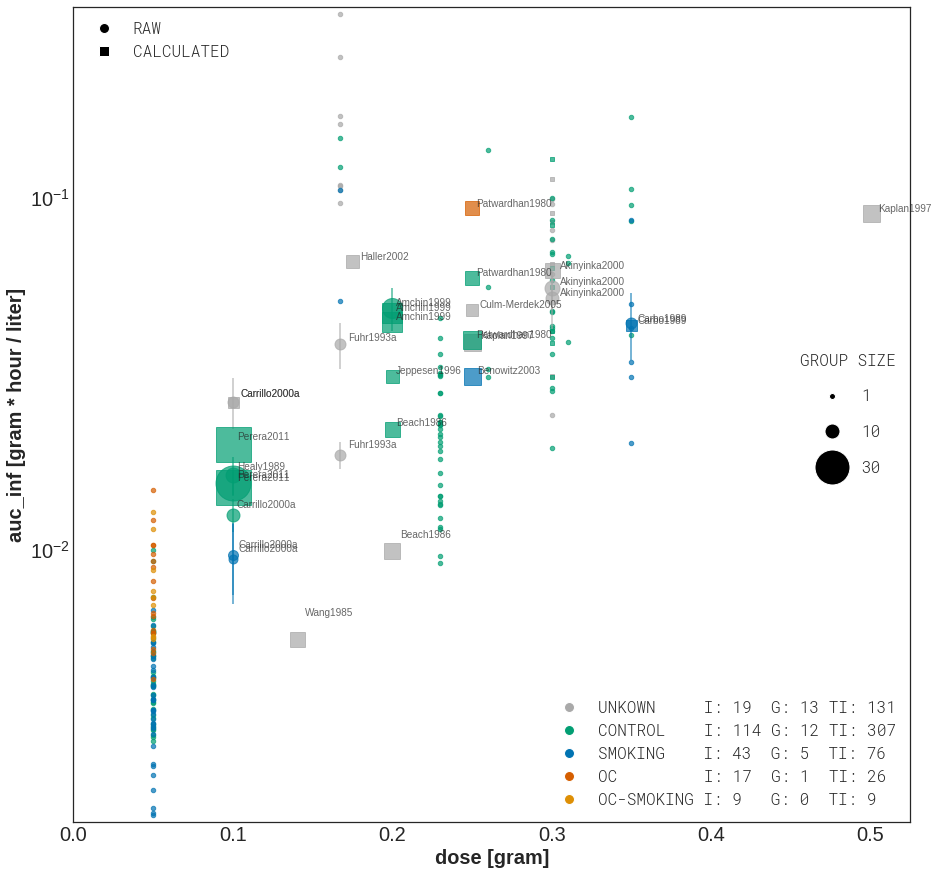

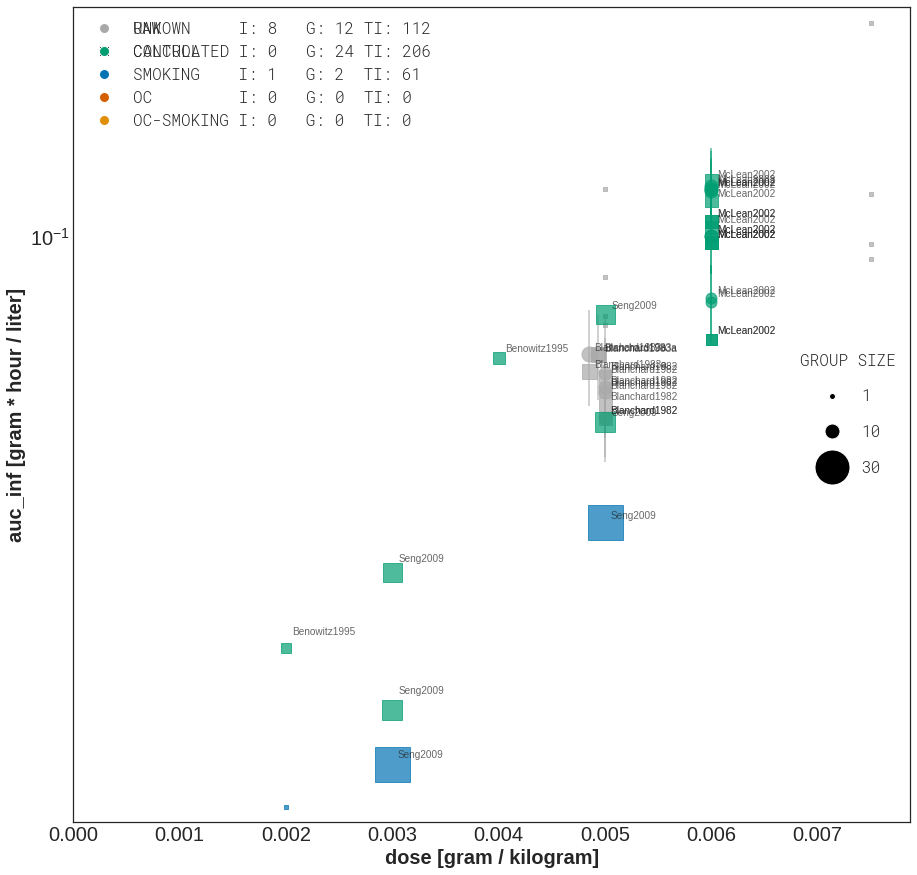

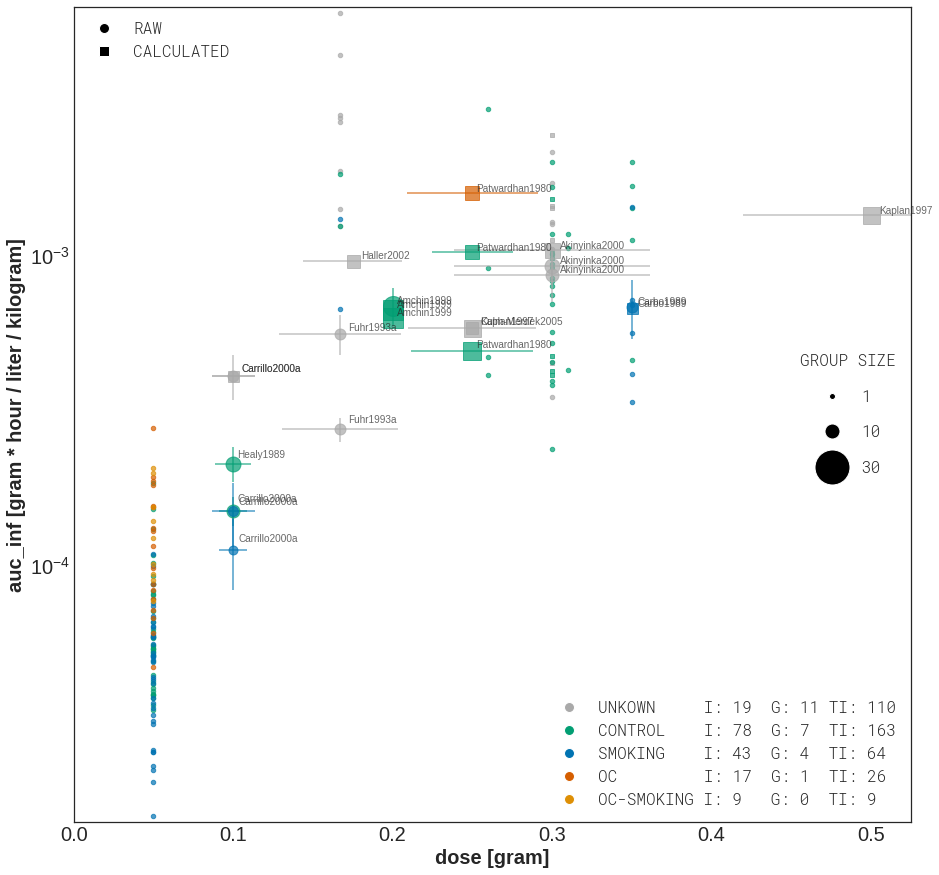

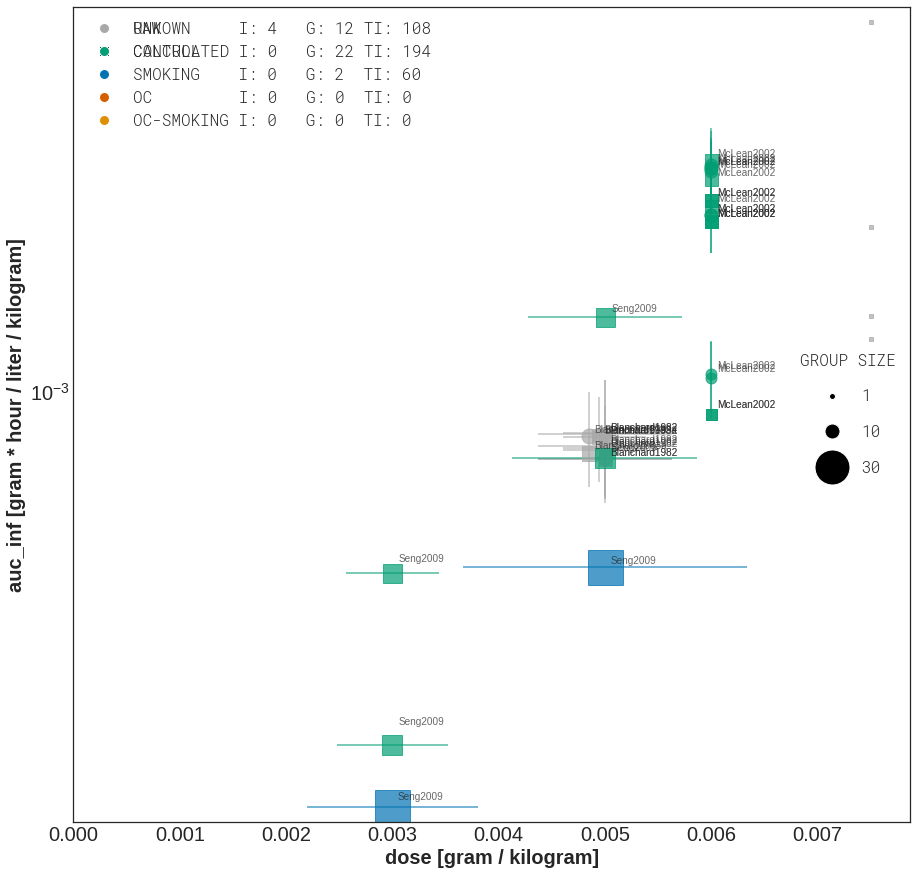

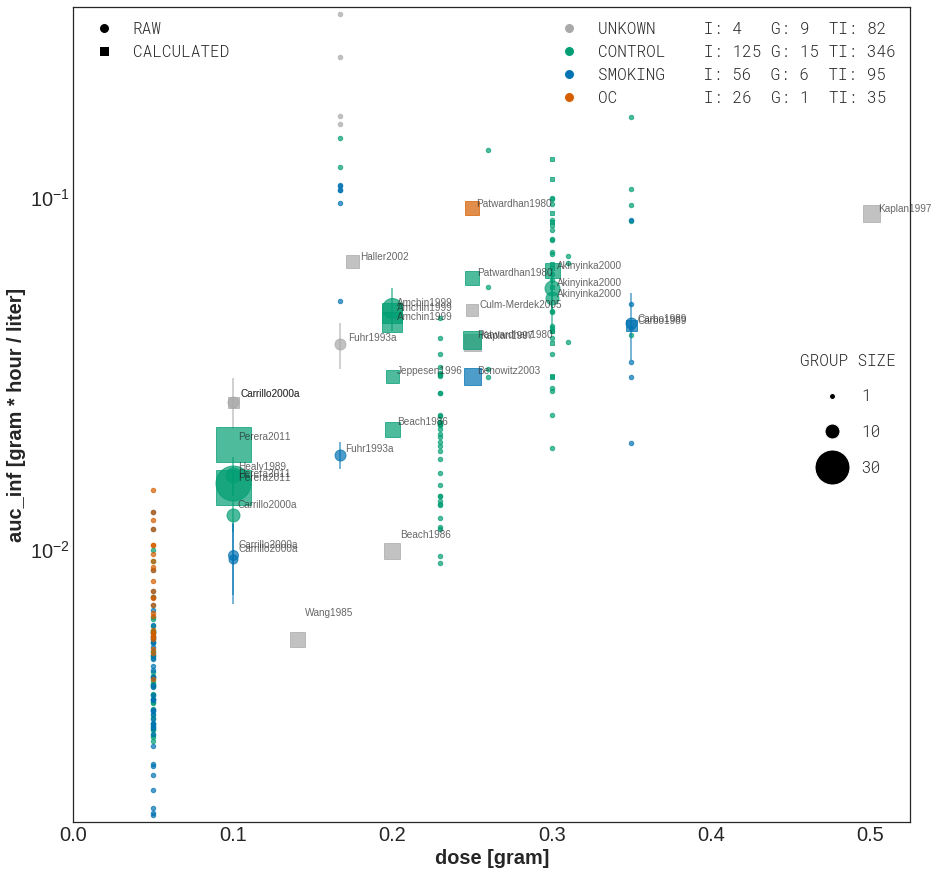

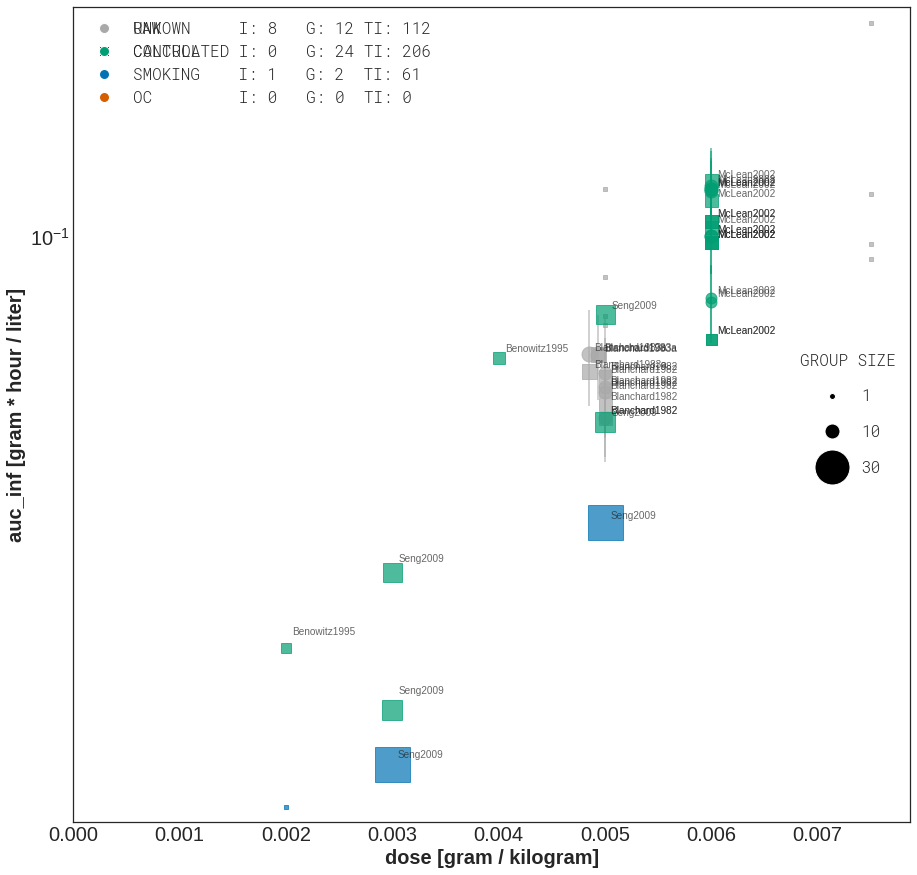

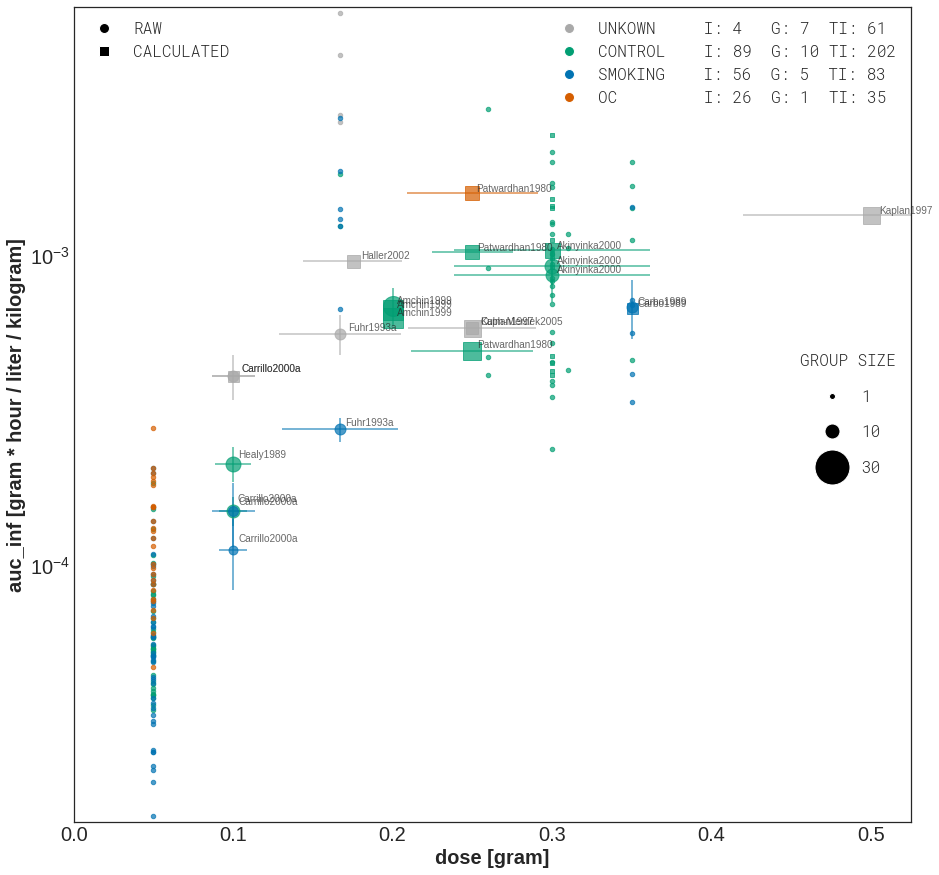

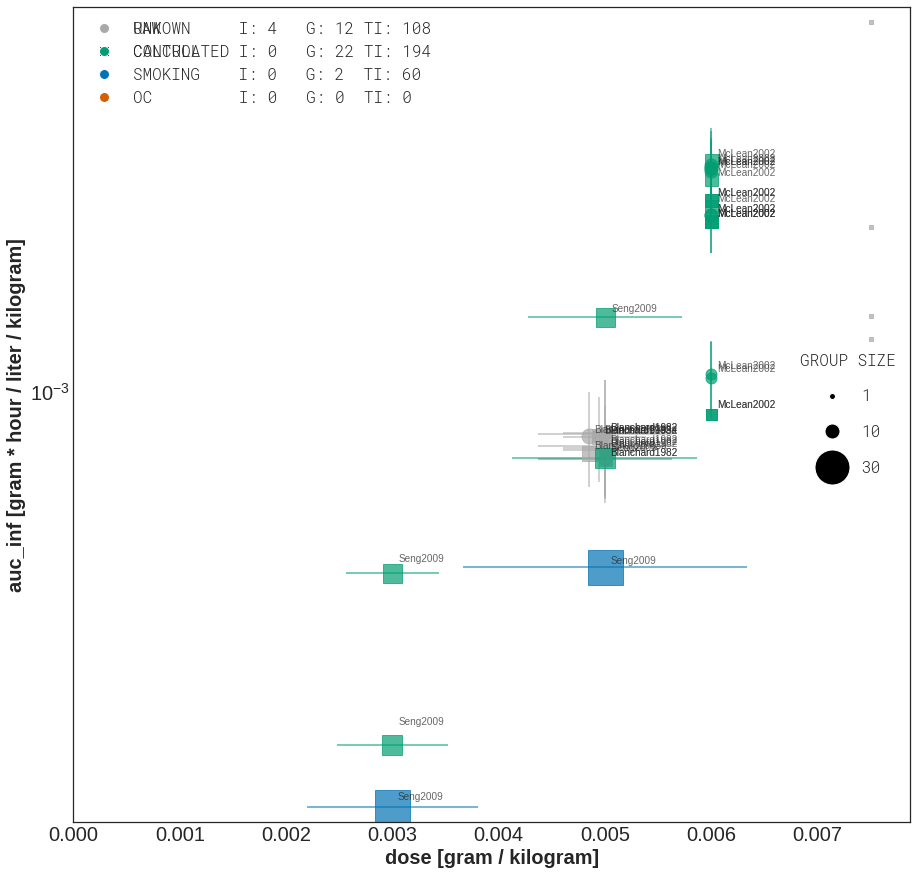

In [31]:
create_plots(caffeine_instance_data,categories_strict,"reports/strict","auc_inf", log_y=True)
create_plots(caffeine_instance_data,categories_soft,"reports/soft","auc_inf", log_y=True)

In [32]:
caffeine_instance = PkdbModel("caffeine_kel",destination="3-inferred")
caffeine_instance.read()
caffeine_instance_data = caffeine_instance.data
caffeine_instance_data["outlier"] = False
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Balogh1992","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1988","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1989","outlier"] = True

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 9   G: 34 TI: 271
CONTROL    I: 53  G: 34 TI: 404
SMOKING    I: 40  G: 5  TI: 123
OC         I: 22  G: 2  TI: 36 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 13  G: 31 TI: 244
CONTROL    I: 53  G: 32 TI: 338
SMOKING    I: 41  G: 4  TI: 112
OC         I: 22  G: 2  TI: 36 
OC-SMOKING I: 9   G: 0  TI: 9  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 4   G: 33 TI: 256
CONTROL    I: 58  G: 35 TI: 419
SMOKING    I: 49  G: 5  TI: 132
OC         I: 31  G: 2  TI: 45 


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 8   G: 30 TI: 229
CONTROL    I: 58  G: 33 TI: 353
SMOKING    I: 50  G: 4  TI: 121
OC         I: 31  G: 2  TI: 45 


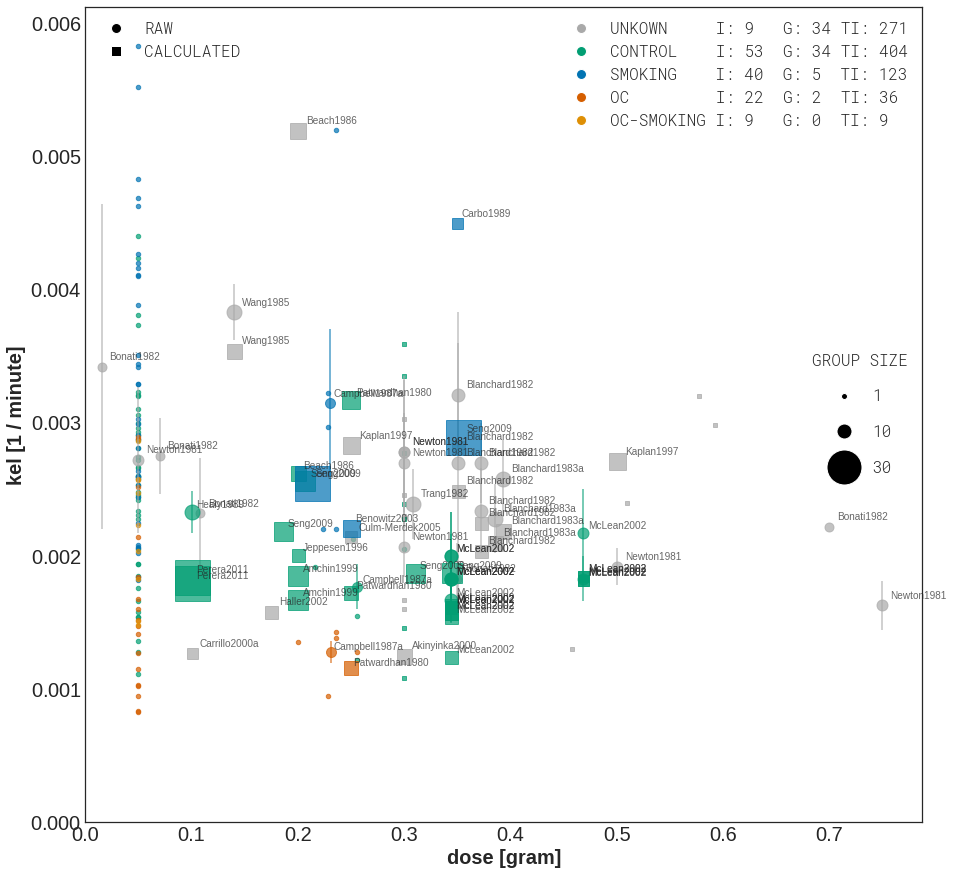

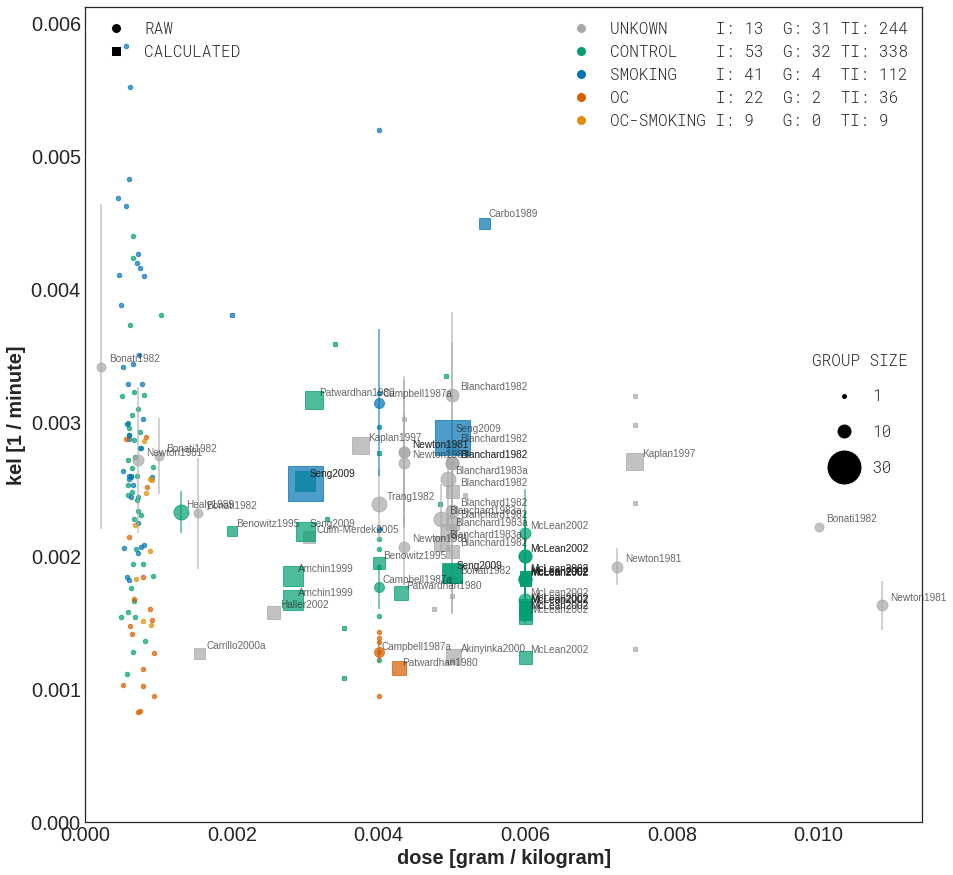

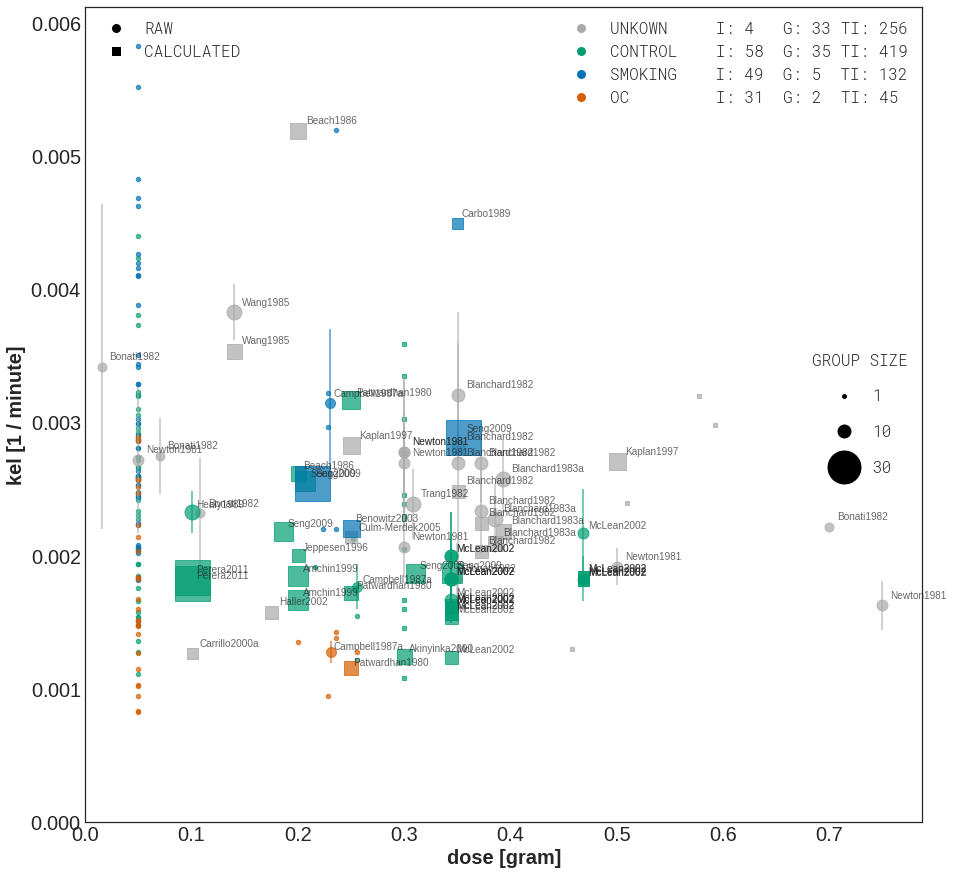

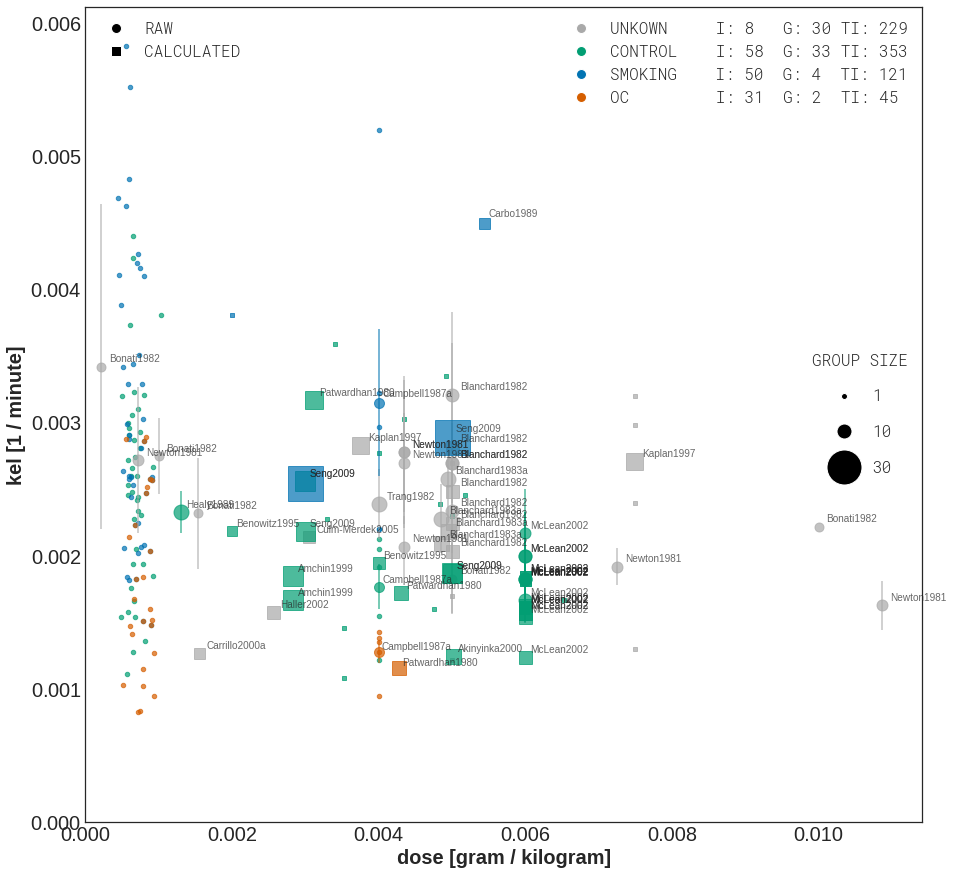

In [33]:
create_plots(caffeine_instance_data,categories_strict,"reports/strict","kel")
create_plots(caffeine_instance_data,categories_soft,"reports/soft","kel")

In [34]:
caffeine_thalf.dropna(axis=0, subset=["group_count"])[["mean", "group_count","sd","se","cv","unit"]]

mean  group_count        sd        se     cv   unit
7     7.200000         10.0  3.000000  0.949000  0.417     hr
8     9.220000         10.0       NaN       NaN    NaN     hr
9     6.000000          8.0  1.700000  0.601000  0.283     hr
11    7.880000          9.0       NaN  0.490000  0.187     hr
12    5.370000          9.0       NaN  0.620000  0.346     hr
29    2.190000         11.0  0.440000  0.133000  0.201     hr
30    2.230000         11.0       NaN       NaN    NaN     hr
31    2.090000          9.0  0.410000  0.137000  0.196     hr
32    2.650000          2.0  0.350000  0.247000  0.132     hr
105   3.320000         10.0  0.840000  0.266000  0.253     hr
106   4.150000         10.0  1.590000  0.503000  0.383     hr
107   4.190000         10.0  1.260000  0.398000  0.301     hr
108   3.960000         10.0  1.210000  0.383000  0.306     hr
109   4.440000         10.0  1.480000  0.468000  0.333     hr
110   4.820000         10.0  2.410000  0.762000  0.500     hr
111   4.660000         10.0  2.110000  0.667000  0.453     hr
112   4.700000         10.0  1.520000  0.481000  0.323     hr
113   6.100000         15.0  3.550000  0.917000  0.582     hr
114   6.920000         15.0       NaN       NaN    NaN     hr
115   6.250000         15.0       NaN       NaN    NaN     hr
116   4.300000         10.0  1.020000  0.323000  0.237     hr
117   4.400000         10.0       NaN       NaN    NaN     hr
118   4.650000          6.0       NaN  1.810000  0.953     hr
119   2.570000          6.0       NaN       NaN    NaN     hr
124   4.600000         12.0  2.200000  0.635000  0.478     hr
125   5.220000         12.0       NaN       NaN    NaN     hr
126   6.320000          6.0  2.500000  1.020000  0.396     hr
127   9.070000          6.0       NaN       NaN    NaN     hr
128   2.380000          5.0  1.220000  0.546000  0.513     hr
129   3.810000          8.0  1.000000  0.354000  0.262     hr
...        ...          ...       ...       ...    ...    ...
1702  0.120557          8.0       NaN  0.014808  0.347  hr/kg
1703  0.130662          8.0       NaN       NaN    NaN  hr/kg
1704  0.123345          8.0       NaN       NaN    NaN  hr/kg
1705  0.128223          8.0       NaN       NaN    NaN  hr/kg
1706  0.124216          8.0       NaN       NaN    NaN  hr/kg
1707  0.128223          8.0       NaN       NaN    NaN  hr/kg
1708  0.122997          8.0       NaN  0.015679  0.361  hr/kg
1709  0.124216          8.0       NaN       NaN    NaN  hr/kg
1710  0.162369          8.0       NaN       NaN    NaN  hr/kg
1711  0.080128          6.0       NaN       NaN    NaN  hr/kg
1712  0.080513          6.0       NaN  0.007051  0.215  hr/kg
1713  0.081538          6.0       NaN       NaN    NaN  hr/kg
1714  0.073077          6.0       NaN  0.009615  0.322  hr/kg
1715  0.080128          6.0       NaN       NaN    NaN  hr/kg
1716  0.081538          6.0       NaN       NaN    NaN  hr/kg
1717  0.059296         30.0  0.020000  0.003648  0.337  hr/kg
1718  0.072113         30.0  0.015211  0.002775  0.211  hr/kg
1719  0.063803         30.0       NaN       NaN    NaN  hr/kg
1720  0.056338         30.0       NaN       NaN    NaN  hr/kg
1721  0.077258         14.0  0.036290  0.009694  0.470  hr/kg
1722  0.099839         14.0       NaN       NaN    NaN  hr/kg
1723  0.082581         14.0  0.048871  0.013065  0.592  hr/kg
1724  0.085000         14.0       NaN       NaN    NaN  hr/kg
1725  0.080580         15.0  0.031304  0.008087  0.388  hr/kg
1726  0.089420         15.0       NaN       NaN    NaN  hr/kg
1727  0.065362         15.0       NaN       NaN    NaN  hr/kg
1728  0.070435         15.0  0.023043  0.005957  0.327  hr/kg
1729  0.073973          6.0  0.034247  0.013973  0.463  hr/kg
1730  0.062857         10.0       NaN       NaN    NaN  hr/kg
1731  0.069444          5.0       NaN  0.010417  0.335  hr/kg

[460 rows x 6 columns]

In [35]:
caffeine_absolute = caffeine_thalf[caffeine_thalf["unit"]=="hour"]
caffeine_absolute = caffeine_absolute[caffeine_absolute["unit_intervention"] == "gram / kilogram"]

caffeine_absolute = caffeine_absolute[~caffeine_absolute["outlier"]]

caffeine_absolute = caffeine_absolute.dropna(subset=["value"])


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/numpy/lib/histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
No handles with labels found to put in legend.


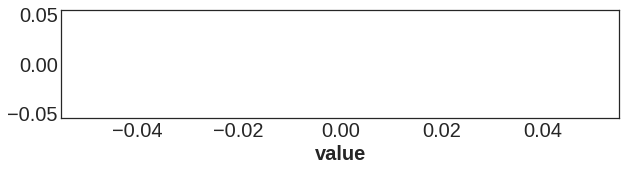

In [36]:

plt.figure(figsize= (10,2))
sns.distplot(caffeine_absolute[smoking_idx(caffeine_absolute)]["value"], bins=None,   color="blue");
sns.distplot(caffeine_absolute[oc_idx(caffeine_absolute)]["value"], bins=None,  color="green");
#sns.distplot(caffeine_absolute[oc_smoking_strict(caffeine_absolute)]["value"], bins=20,   label="oc_smoking");
sns.distplot(caffeine_absolute[control_idx(caffeine_absolute)]["value"], bins=None, color="black");
#sns.distplot(caffeine_thalf[rest_idx(caffeine_thalf)]["value"], bins=20, kde=False, label="unknown");

plt.legend()



In [37]:

caffeine_absolute = caffeine_thalf[caffeine_thalf["unit"]=="hr"]
caffeine_absolute = caffeine_absolute[caffeine_absolute["unit_intervention"] == "mg"]
caffeine_absolute = caffeine_absolute.dropna(subset=["mean"])
caffeine_absolute = caffeine_absolute[~caffeine_absolute["outlier"]]

frames = []
for i, data in caffeine_absolute.iterrows():
    for _ in range(int(data["group_count"])):
        data["value"] = data["mean"]
        frames.append(data)

caffeine_absolute1 =  pd.concat(frames, axis=1).T


frames = []
for i, data in caffeine_absolute.iterrows():
    mean = data["mean"]
    sd = data["sd"]
    for _ in range(int(data["group_count"])):
        
        if not np.isnan(sd):
            value = -1

            while value < 0:
                value = np.random.normal(mean,sd)
            data["value"] = value

            

        else:
            data["value"] = data["mean"]
            
        frames.append(data)

caffeine_absolute2 =  pd.concat(frames, axis=1).T


In [38]:
len(caffeine_absolute2)

1310

In [39]:
caffeine_absolute = caffeine_thalf[caffeine_thalf["unit"]=="hour"]
caffeine_absolute = caffeine_absolute[caffeine_absolute["unit_intervention"] == "gram"]
caffeine_absolute = caffeine_absolute[~caffeine_absolute["outlier"]]
len(caffeine_absolute)

0

In [40]:
#caffeine_absolute = caffeine_absolute1
#caffeine_absolute = caffeine_absolute2
#caffeine_absolute = caffeine_absolute.reset_index()

caffeine_absolute = caffeine_absolute.dropna(subset=["value"]).append(caffeine_absolute1)
len(caffeine_absolute)

1310

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


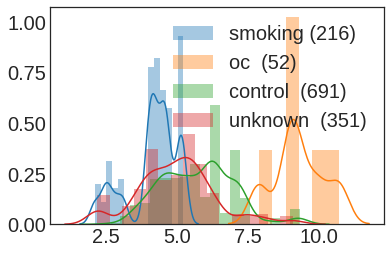

In [41]:
smoking = caffeine_absolute[smoking_idx(caffeine_absolute)]["value"].to_list()
oc = caffeine_absolute[oc_idx(caffeine_absolute)]["value"].to_list()
control = caffeine_absolute[control_idx(caffeine_absolute)]["value"].to_list()
rest = caffeine_absolute[rest_idx(caffeine_absolute)]["value"].to_list()

sns.distplot(smoking, bins=None,   label=f"smoking ({len(smoking)})")
sns.distplot(oc, bins=None,  label=f"oc  ({len(oc)})")
sns.distplot(control, bins=None, label=f"control  ({len(control)})")
sns.distplot(rest, bins=None, label=f"unknown  ({len(rest)})")

plt.legend()

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


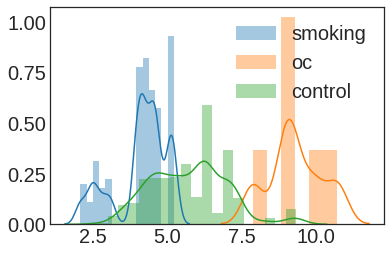

In [42]:
#caffeine_absolute = caffeine_absolute1
caffeine_absolute = caffeine_absolute1
caffeine_absolute = caffeine_absolute.reset_index()

sns.distplot(caffeine_absolute[smoking_idx(caffeine_absolute)]["mean"].to_list(), bins=None,   label="smoking")
sns.distplot(caffeine_absolute[oc_idx(caffeine_absolute)]["mean"].to_list(), bins=None,  label="oc")
sns.distplot(caffeine_absolute[control_idx(caffeine_absolute)]["mean"].to_list(), bins=None, label="control")
plt.legend()

In [43]:
caffeine_instance = PkdbModel("caffeine_vd",destination="3-inferred")
caffeine_instance.read()
caffeine_instance_data = caffeine_instance.data
caffeine_instance_data["outlier"] = False
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Balogh1992","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1988","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1989","outlier"] = True

In [44]:
caffeine_instance_data.columns.to_list()

#yinterp = interpolate.UnivariateSpline(x, y, s = 5e8)(x) 


['study',
 'output_type',
 'pk',
 'access',
 'measurement_type',
 'tissue',
 'allowed_users',
 'substance',
 'interventions',
 'raw_pk',
 'unit',
 'calculated',
 'individual_name',
 'individual_pk',
 'value',
 'group_pk',
 'group_name',
 'group_count',
 'mean',
 'timecourse_pk',
 'time_unit',
 'time',
 'se',
 'cv',
 'sd',
 'pharmacokinetics',
 'figure',
 'max',
 'min',
 'median',
 'choice',
 'raw_pk_intervention',
 'allowed_users_intervention',
 'measurement_type_intervention',
 'access_intervention',
 'route',
 'substance_intervention',
 'unit_intervention',
 'value_intervention',
 'application',
 'time_intervention',
 'time_unit_intervention',
 'form',
 'choice_intervention',
 'min_intervention',
 'max_intervention',
 'se_intervention',
 'sd_intervention',
 'subject_type',
 'subject_pk',
 ('study', ''),
 ('subject_name', ''),
 ('species', 'choice'),
 ('species', 'count'),
 ('healthy', 'choice'),
 ('healthy', 'count'),
 ('sex', 'choice'),
 ('sex', 'count'),
 ('age', 'count'),
 ('age',

In [45]:
import matplotlib.pyplot as plt
from scipy import interpolate

unit_intervention = "gram"
unit = "liter / hour"

caffeine_abs_abs= caffeine_clearance[(caffeine_clearance["unit_intervention"] == unit_intervention) &(caffeine_clearance["unit"] == unit)]#[["value","value_intervention"]]
caffeine_abs_abs["value"] = caffeine_abs_abs["mean"]
for category in categories_soft:
    d = caffeine_abs_abs[category.data_idx(caffeine_abs_abs)]
    d.sort_values("value_intervention", inplace=True)
    linear_fit = np.polyfit(d["value_intervention"], d["value"], 3)
    #sns.regplot("value_intervention","value", d, order=3,truncate=True, label =category.name,)
    
    #yinterp = interpolate.UnivariateSpline(d["value_intervention"],d["value"], s = 5e8)(d["value_intervention"]) 
    #plt.plot(x, y, 'bo', label = 'Original')
    #plt.plot(x, yinterp, 'r', label = 'Interpolated'
plt.legend()

TypeError: expected non-empty vector for x

In [ ]:
caffeine_clearance[(caffeine_clearance["outlier"] == False) &
(caffeine_clearance["unit_intervention"] == "gram / kilogram") &(caffeine_clearance["unit"] == "liter / hour / kilogram")].sort_values("value",ascending=False)[["study","value"]]